# Behavioral simulation using EP-LHb-DAN model
### Shun | Elliot

##### Framework:
- Dataset: MNIST (learns much easier)
- Loss: MSE
- Layer: TopK w/ Sign Switching
    - currently using positive sign pattern/no update sign for EP and LHb
    - currently using negative sign pattern/no update sign for DAN.
    - ^^ This is able to shift activations to a significant point.
        - However, adding in mixed sign pattern makes activations not shift/learn.

##### New Updates (12/16):
- calculate absolute distance (open to changing method of calculating distance)
    - for each clothes category
    - resets/calculates every epoch
- Using Maceo Train Function (cleaner result display, not too much benefit to network learning)

##### New Updates (12/17):
- opto category = 4
- random/reward/punish = 0.5/1/0
    - consistent correct LHb activation change
- updated choose_neuron (chooses top activated neurons)
    - saving storage space/ runtime
- mean line on plot_activation


##### General Notes:
- Network learns super well (random/reward/punish) using MSE with maceo's original topKlinear layers.
- Once we add in sign switching (particularly mixed), network messes up.
- Correct activation change in DAN is very consistent, but correct activation change in LHb is not consistent (12/16/24)
    - (12/17/24): LHb change much more consistent
- Briefly tried Relu with fixed positive bias, and network performs much worse.
- weight plots at the bottom of notebook (random/reward/punish for opto/lowest/all neurons) and EI index
    - doesn't line up with our prediction/thinking
    - exp() 


In [5]:



import torch.autograd as ag
from torch.nn.utils import clip_grad_value_
import pickle

In [6]:
# Fashion MNIST MLP
import torchvision
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
import random
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from collections import Counter

from collections import defaultdict
from torch.nn.utils import clip_grad_value_

import os
import json
import time

import wandb

In [7]:
from math import floor
from copy import deepcopy




TOPK_INIT_METHODS = {
    'xavier_normal': nn.init.xavier_normal_,
    'xavier_uniform': nn.init.xavier_uniform_,
    'kaiming_normal': nn.init.kaiming_normal_,
    'kaiming_uniform': nn.init.kaiming_uniform_,
    'orthogonal': nn.init.orthogonal_,
    'normal': nn.init.normal_,
    'uniform': nn.init.uniform_,
    'eye': nn.init.eye_,
}


class TopKLinear(nn.Module):
    """
    A linear layer that retains only the top K strongest synaptic weights for
    in_features.

    This module implements a linear transformation with weights constrained to 
    be positive. For each output neuron, only the top K weights are kept 
    , and the rest are set to zero. This simulates a neuron receiving 
    inputs only from its strongest synaptic connections.

    Parameters
    ----------

    in_features : int
        The number of input features.
    
    out_features : int
        The number of output features.

    K : int
        The number of strongest synapses to keep per dendritic branch.

    param_space : str, optional
        The parameter space for the weights. Options are 'log' and 'presigmoid'.
        If `'log'`, the weights are parameterized as exponentials of `pre_w`.
        If `'presigmoid'`, the weights are parameterized as sigmoids of `pre_w`.
        Defaults to 'log'.
    
    Attributes
    ----------

    pre_w : torch.nn.Parameter
        The raw weights before applying the exponential or sigmoid 
        transformation. Initialized with small negative values to ensure 
        positive weights after transformation.

    K : int
        The percentage of strongest synapses to keep per dendritic branch.

    param_space : str
        The parameter space for the weights.

    Methods
    -------

    forward(x)
        Performs a forward pass through the layer.

    weight()
        Returns the transformed synaptic weights after applying the exponential 
        or sigmoid.
    
    weight_mask()
        Returns a mask tensor indicating the top K synaptic connections per 
        output neuron.

    pruned_weight()
        Returns the pruned synaptic weights after applying the mask.

    weighted_synapses(cell_weights, prune=False)
        Returns the weighted synapses for a given set of cell

    Notes
    -----
    - All weights are constrained to be positive.
    - The prunning is done dynamically during the forward pass.

    Examples
    --------

    >>> import torch
    >>> from torch import nn
    >>> topk_linear = TopKLinear(in_features=10, out_features=5, K=3)
    >>> x = torch.randn(4, 10)  # Batch of 4 samples
    >>> output = topk_linear(x)
    >>> print(output.shape)
    torch.Size([4, 5])
    """
    def __init__(
        self,
        in_features,
        out_features,
        K,
        param_space='log',
        init_method='xavier_normal',
        sign_pattern='mixed',  # Default: mixed signs
        update_sign=False,  # Default: sign matrix is not trainable
    ):
        super(TopKLinear, self).__init__()
        self.pre_w = nn.Parameter(
            torch.empty((out_features, in_features)), requires_grad=True)

        self.sign_matrix = nn.Parameter(
            torch.empty((out_features, in_features)), requires_grad=False)
        
        self.K = round(K/100 * in_features)
        self.param_space = param_space
        self.init_method = init_method
        self.update_sign = update_sign # update sign based on gradient

        self.initialize_signs(sign_pattern)
        self.initialize_weights()
        self.final_weight = self.weight().detach()

    def initialize_signs(self, sign_pattern):
        """Initialize the sign matrix based on the desired pattern."""
        if sign_pattern == 'mixed':
            self.sign_matrix.data.uniform_(-1, 1)
            self.sign_matrix.data = self.sign_matrix.sign()  # Values: -1 or 1
        elif sign_pattern == 'negative':
            self.sign_matrix.data.fill_(-1)  # All weights negative
        elif sign_pattern == 'positive':
            self.sign_matrix.data.fill_(1)  # All weights positive
        else:
            raise ValueError("Invalid sign pattern. Choose 'mixed', 'negative' or 'positive'.")

    def initialize_weights(self):
        """Initialize the raw weights using the specified method."""
        if self.init_method in TOPK_INIT_METHODS:
            init_func = TOPK_INIT_METHODS[self.init_method]
            init_func(self.pre_w)
            #TODO: Accept hyperparameters for initialization
            # init_func(self.pre_w, **self.init_params) 
        else:
            raise ValueError(
                f"Invalid initialization method: {self.init_method}. "
                f"Choose from {list(TOPK_INIT_METHODS.keys())}")

    def forward(self, x):
        """Perform the forward pass."""
        final_weight = self.weight()
        mm = torch.mm(x, final_weight.t())

        # matrix multiply inputs and synaptic weights
        if self.sign_matrix != "negative":
            return torch.sigmoid(mm)
        else:
            return mm
        
    
    def weight(self):
        """Return the final weights."""
        if self.param_space == 'log':
            final_weight = self.pre_w.exp() * self.sign_matrix
        elif self.param_space == 'presigmoid':
            final_weight = torch.sigmoid(self.pre_w) * self.sign_matrix

        # scale weight
        final_weight = final_weight * 0.01
        self.final_weight = final_weight.detach()
        return final_weight
    
    def update_signs(self):
        """
        Dynamically switch signs based on gradients
        """
        if self.update_sign:
            with torch.no_grad():
                # Access gradients of log_weights
                grads = self.pre_w.grad  

                 # Compute the condition: W * grad(W) < 0
                 # i.e. gradient opposes weight direction
                flip_mask = (self.weight() * grads) < 0

                # Flip the signs to match the gradient
                self.sign_matrix[flip_mask] *= -1
    
    def decay_weights(self, weight_decay = 0.1):
        with torch.no_grad():
            self.pre_w.data -= (weight_decay * self.weight_mask())
    
    def weight_mask(self):
        """Generate a mask for the top K strongest connections."""
        topK_indices = torch.topk(self.pre_w, self.K, dim=-1, largest=True, sorted=False)[1]
        # initialize and populate masking matrix
        mask = torch.zeros_like(
            self.pre_w, device=self.pre_w.device, dtype=self.pre_w.dtype)
        mask[torch.arange(self.pre_w.shape[0])[:, None], topK_indices] = 1
        return mask
    

In [8]:
class Corelease_Model(nn.Module):
    """
    Model follows co-release: regular MLP

    if real: make DAN weights pure inhib
    """
    def __init__(self, in_features=784, h1=512, h2=512, out_features=11, dropout_rate=0, real=False, 
                 combine_EI=False, dales_law=False, opto_neuron_percent=0.4, batch_size=256, 
                 opto_on=False, log_weights=True):
        super().__init__()

        self.EP = TopKLinear(in_features=in_features, out_features=h1, K=100, sign_pattern="positive", update_sign=False)
        self.bn1 = nn.BatchNorm1d(h1)
        self.LHb = TopKLinear(in_features=h1, out_features=h2, K=100, sign_pattern="positive", update_sign=True)
        self.bn2 = nn.BatchNorm1d(h2)
        if dropout_rate != 0: self.dropout = nn.Dropout(dropout_rate)
        self.DAN = TopKLinear(in_features=h2, out_features=out_features, K=100, sign_pattern="negative", update_sign=False)

        self.opto_on = opto_on
        self.opto_neuron_percent = opto_neuron_percent
        self.init_weights = self.record_params(calc_sign=False)
        self.train_losses = []
        self.valid_losses = []
        
        # store opto idx
        self.opto_idx_batch = None
        self.EP_current_act = None
        self.EP_current_train_act = None
        self.opto_tag = False
        self.opto_choose_neuron = None
        self.lowest_choose_neuron = None


    def forward(self, x, labels=None):
        """
        Forward pass with optional label handling for training.
        At Opto Activation:
        x size = ([batch_size, layer_size])
        set certain % of EP hidden layer neurons' activation values = 95th percentile of batch's activation values.
        """
        x = x.view(x.size(0), -1)  # Flatten input

        # Pass through the first layer, apply batch normalization and activation
        x = self.EP(x)  # Apply EP (TopKLinear or nn.Linear)
        self.EP_current_act = x
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        
        x = self.bn1(x)  # Apply BatchNorm1d

        # Pass through the second layer, apply batch normalization and activation
        x = self.LHb(x)  # Apply LHb (TopKLinear or nn.Linear)
        #x = torch.sigmoid(x)  # Apply sigmoid activation
        x = self.bn2(x)  # Apply BatchNorm1d

        # Apply dropout for regularization
        if hasattr(self, 'dropout'):  
            x = self.dropout(x)

        # Pass through the final layer
        x = self.DAN(x)

        # If labels are provided, compute loss
        if labels is not None:
            print("COMPUTING LOSS")
            nll_loss = torch.nn.functional.cross_entropy(x, labels)
            return nll_loss

        # Return logits for inference
        return x

    def record_params(self, calc_sign: bool = True):
        """ Save the network weights. """
        recorded_params = {}

        # Loop through all modules
        for name, module in self.named_modules():
            if isinstance(module, TopKLinear):  # Check if it's a TopKLinear layer
                # Store pre_w
                if module.pre_w.requires_grad:
                    with torch.no_grad():
                        recorded_params[name + '.pre_w'] = module.pre_w.data.detach().cpu().clone()
                else:
                    recorded_params[name + '.pre_w'] = module.pre_w.data.detach().cpu().clone()

                # Store sign_matrix
                if module.sign_matrix.requires_grad:
                    with torch.no_grad():
                        recorded_params[name + '.sign_matrix'] = module.sign_matrix.data.detach().cpu().clone()
                else:
                    recorded_params[name + '.sign_matrix'] = module.sign_matrix.data.detach().cpu().clone()

                # Store final_weight
                if module.final_weight.requires_grad:
                    with torch.no_grad():
                        recorded_params[name + '.final_weight'] = module.final_weight.data.detach().cpu().clone()
                else:
                    recorded_params[name + '.final_weight'] = module.final_weight.data.detach().cpu().clone()
        # Calculate the percentage of positive, negative, and zero weights
        if calc_sign:
            for name, cur_data in recorded_params.items():
                frac_pos = 100 * (torch.sum(cur_data > 0) / cur_data.numel()).numpy()
                frac_zero = 100 * (torch.sum(cur_data == 0) / cur_data.numel()).numpy()
                frac_neg = 100 * (torch.sum(cur_data < 0) / cur_data.numel()).numpy()
                print(name + f': Positive: {frac_pos:.2f}%; Negative: {frac_neg:.2f}%; Zero: {frac_zero:.2f}%')

        return recorded_params

In [9]:
class CustomWeightDecayOptimizer(object):

    def __init__(self, model, optimizer, weight_decay=0.1):
        self.model = model
        self.optimizer = optimizer
        self.weight_decay = weight_decay
    
    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def step(self):
        lr = self.optimizer.param_groups[0]['lr']
        for param in self.model.parameters():
            if param.requires_grad:
                param.data -= lr * self.weight_decay * param.data
        self.optimizer.step()

class TrainerMLE(object):
    """
    Maximum Likelihood Estimation (MLE) trainer for training probabilistic 
    models. 

    Parameters
    ----------
    optimizer : torch.optim.Optimizer
        The optimizer used to update the model parameters during training.

    suppress_prints : bool, optional
        Whether to suppress print statements during training. Default is False.

    print_every : int, optional
        The frequency with which to print training updates. Default is 10.

    Methods
    -------

    train(model, train_data, valid_data, grad_clip_value=5, epochs=100,
            batch_size=256, shuffle=True, plot_losses=False, save_path=None)
            Trains the model on the training data and validates on the 
            validation data.

    Notes
    -----
      - The model must implement a `log_prob` method that computes the log 
        probability of observing the labels given the inputs.
      - train_data: Data object containing training data.
      - valid_data: Data object containing validation data.

    """
    
    def __init__(self, optimizer, suppress_prints=False, print_every=1):
        self.optimizer = optimizer
        self.suppress = suppress_prints
        self.print_every = print_every
    

    def train(
            self, 
            model, 
            train_data, 
            valid_data, 
            grad_clip_value=5,
            epochs=5,
            loss_function = "CrossEntropy",
            batch_size=256, 
            shuffle=True, 
            load_best_state_dict=True,
            plot_losses=False, 
            save_path=None,
            ):
        """
        Trains a model using maximum likelihood estimation.

        Parameters
        ----------

        model : ProbabilisticModel
            The model to be trained. Must implement a `log_prob` method that 
            computes the log probability of observing the labels given the 
            inputs.

        train_data : Data
            The training data.

        valid_data : Data
            The validation data.

        grad_clip_value : float, optional
            The value at which to clip the gradients to prevent exploding 
            gradients. Default is 5.

        epochs : int, optional
            The number of epochs to train the model. Default is 100.

        batch_size : int, optional
            The batch size used during training. Default is 256.

        shuffle : bool, optional    
            Whether to shuffle the data during training. Default is True.

        plot_losses : bool, optional
            Whether to plot the training and validation losses. 
            Default is False.

        save_path : str, optional
            Directory to save checkpoints and loss curves if provided.

        Returns
        -------

        dict
            A dictionary containing the best epoch, training losses, and
            validation losses. If `plot_losses` is True, the dictionary will
            also contain a figure object for the loss curves and the figure
            will be saved to `save_path` if provided.

        """

        # whether to save at checkpoints
        save_boolean = save_path is not None and os.path.exists(save_path)
        
        # send model to device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = model.to(device)
        
        # create dataloader objects for training data and validation data
        train_dataloader = DataLoader(train_data, 
                                      batch_size=256, 
                                      shuffle=shuffle)
        valid_dataloader = DataLoader(valid_data, 
                                      batch_size=256, 
                                      shuffle=shuffle)
        
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []
        
        
        stime = time.time()
        
        best_loss = float('inf')
        best_state_dict = deepcopy(model.state_dict())

        for epoch in range(1, epochs + 1):        
            train_loss = 0
            valid_loss = 0
            correct_train = 0
            total_train = 0
            correct_valid = 0
            total_valid = 0
            distance_dict = {key: [0, 0] for key in range(10)}
            model.EP_current_act = None
            model.opto_idx_batch = None
            
            
            model.train()
            # iterate over the training data
            for input_batch, (stim_label_batch, og_label_batch) in train_dataloader:
                model.opto_idx_batch = [z for z, x in enumerate(og_label_batch.tolist()) if x == opto_category]

                try:
                    input_batch = ag.Variable(input_batch.to(device))
                    stim_label_batch = ag.Variable(stim_label_batch.to(device))
                    og_label_batch = ag.Variable(og_label_batch.to(device))
                    
                    
                    outputs = model(input_batch)

                    model.EP_current_train_act = model.EP_current_act

                    model.opto_choose_neuron = choose_neuron(model.EP_current_train_act, model.opto_idx_batch, True)
                    model.lowest_choose_neuron = choose_neuron(model.EP_current_train_act, model.opto_idx_batch, False)

                    loss = criterion(outputs, stim_label_batch)
                    
                    # zero gradients
                    self.optimizer.zero_grad()
                    # backpropagate loss
                    loss.backward()
                    
                    # prevent exploding gradients
                    clip_grad_value_(model.parameters(), grad_clip_value)
                    
                    # update weights
                    self.optimizer.step()
                    
                    model.LHb.update_signs()
                    
                    # aggregate training loss
                    train_loss += loss.item()

                    
                
                except Exception as e:
                    print(f"Exception: {e}")
                    print("EXCEPTION IS HERE")
                    train_loss += 10

            model.EP_activations_ls = []
            model.opto_idx_trainset = []
            # compute mean training loss and save to list
            train_loss /= len(train_dataloader)
            train_losses.append(train_loss)
            #train_accuracy = correct_train / total_train
            #train_accuracies.append(train_accuracy)
            
            model.eval()
            with torch.no_grad():
                # iterate over validation data
                for input_batch, (stim_label_batch, og_label_batch) in valid_dataloader:
                    try:
                        # produce negative log likelihood
                        outputs = model(input_batch.to(device))
                        loss = criterion(outputs, stim_label_batch)
                        
                        # compute and aggregate validation loss 
                        valid_loss += loss.item()
                        
                        # validation distance for each category
                        distance_dict = calculate_distance(stim_label_batch, og_label_batch, outputs, distance_dict)
                        
                    except Exception as e:
                        print(f"Exception: {e}")
                        valid_loss += 10
            
            # average distance dict
            distance_dict = {key: value[0] / value[1] for key, value in distance_dict.items()}
            
            # compute mean validation loss and save to list
            valid_loss /= len(valid_dataloader)
            valid_losses.append(valid_loss)

            # save model that performs best on validation data
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_epoch = epoch
                best_state_dict = deepcopy(model.state_dict())
                best_distance_dict = distance_dict

                if save_boolean:
                    torch.save(best_state_dict, os.path.join(save_path, 'state_dict.pt'))

                    with open(os.path.join(save_path, 'losses.json'), 'w') as f:
                        json.dump(
                            {'best epoch': best_epoch,
                             'train losses': train_losses, 
                             'valid losses': valid_losses,
                            'best distance dict': best_distance_dict,
                            }
                        )

            if not self.suppress:
                # printing
                if epoch % self.print_every == 0:
                    print(f' ----   Epoch {epoch}  ---- ')
                    print(f'training loss: {train_loss:.2f} | validation loss: {valid_loss:.2f}')
                    
                    time_elapsed = time.time() - stime
                    pred_time_remaining = (time_elapsed / epoch) * (epochs - epoch)
                    
                    print(f'time elapsed: {time_elapsed:.2f} s | predicted time remaining: {pred_time_remaining:.2f} s')
                    
            if wandb.run is not None:
                wandb.log({"train_loss": float(train_loss), 
                           "valid_loss": float(valid_loss),
                           "epoch": epoch})
        
        results = {
            'best epoch': best_epoch, 
            'train losses': train_losses, 
            'valid losses': valid_losses,
            'best distance dict': best_distance_dict,
        }

        if load_best_state_dict:
            model.load_state_dict(best_state_dict)
        else:
            results['best state dict'] = best_state_dict
        
        return results

In [10]:
def weight_changes(initial_params, trained_params):
    """
    initial weights vs trained weights plot for all layers
    
    """
    #@title What fraction of parameters flip sign?
    for key in initial_params:
        n_weights=initial_params[key].numel()
        n_flip = (initial_params[key].sign()*trained_params[key].sign()<0).count_nonzero().item()
        print(key + ' flipped: % .2f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

    for key in initial_params:
        n_weights=initial_params[key].numel()
        n_changed = (initial_params[key] != trained_params[key]).count_nonzero().item()
        print(key + ' changed: % .2f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

    # Plot initial vs trained values

    fig, axs = plt.subplots(3,int(len(trained_params)/3),figsize=(20, 7))
    plt.subplots_adjust(hspace=0.5)

    ax = 0
    for i, ax in enumerate(axs.flatten()):
        key = list(initial_params)[i]
        ax.scatter(initial_params[key].numpy(),trained_params[key].numpy(),s=10,alpha=0.5)
        ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
        ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
        ax.set_title(key)

    plt.tight_layout()
    plt.show()

In [11]:
def calculate_distance(stim_label_batch, og_label_batch, outputs, distance_dict):
    for i in range(len(outputs)):
        og_label = og_label_batch[i].item()
        stim_label = stim_label_batch[i].item()
        output = outputs[i].item()

        # Update the dictionary
        distance_dict[og_label][0] += abs(stim_label - output)
        distance_dict[og_label][1] += 1
    
    return distance_dict


In [12]:
def plot_distance(results, name):
    # Extract keys and values
    keys = list(results["best distance dict"].keys())
    values = list(results["best distance dict"].values())

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='skyblue')

    # Add labels and title
    plt.xlabel("Category", fontsize=12)
    plt.ylabel("Absolute Error", fontsize=12)
    plt.title(f'Best Absolute Error/Accuracy: Epoch {results["best epoch"]} ({name})', fontsize=14)

    # Customize ticks
    plt.xticks(keys, fontsize=10)
    plt.yticks(fontsize=10)

    # Display grid for clarity
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [13]:
def plot_loss(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(results["train losses"])
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Loss")
    ax1.set_title("Training Loss")
    ax1.set_xticks(range(0, len(results["train losses"])))
    ax1.tick_params(axis='x', rotation=45, labelsize=8)
    
    ax2.plot(results["valid losses"])
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Valid Loss")
    ax2.set_title("Valid Loss")
    ax2.set_xticks(range(0, len(results["train losses"])))
    ax2.tick_params(axis='x', rotation=45, labelsize=6)

In [14]:
class MNIST(Dataset):
    def __init__(self, train_data, out_features, opto_category = None, opto_target = None):
        
        targets = torch.tensor(train_data.targets.tolist())
        data = train_data.data
        
        # stimuli targets: either -1/0/+1
        target_dict = {0: 0, 1: 0.5, 2: 1.0, 3: 0, 4: 0.5, 5: 0.5, 6: 1.0, 7: 1.0, 8: 0.5, 9: 0}
        
        # change target dict to opto category + target
        if opto_category is not None and opto_target is not None:
            target_dict[opto_category] = opto_target
        
        # apply target dictionary
        stim_targets = torch.stack([torch.full((out_features,), target_dict[t.item()]) for t in targets])
            
        # format targets into [stim targets, orig targets]
        stim_targets = [(stim_targets[i], targets[i].item()) for i in range(len(targets))]
        
        
        # Normalize original data
        self.targets = stim_targets
        self.data = data.float() / 255    
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


In [15]:
def choose_neuron(EP_current_train_act, opto_idx, largest, neuron_pct = 0.05, neuron_counter=None):
    """
    Return the indices of the top activation values (?%) of neurons for the given batch.

    Args:
    - EP_current_train_act: Tensor of activation values for the batch (shape: batch_size x num_neurons).
    - opto_idx: List of indices within the batch where images are trained with opto (length: batch_size).
    - neuron_pct: Percentage of top neurons to consider (e.g., 0.05 for top 5%).
    - largest: Boolean to indicate if we are looking for the largest or smallest activations.
    - neuron_counter: A Counter object to keep track of occurrences of neuron activations across batches.

    Returns:
    - top_neurons: List of the most frequently activated neuron indices.
    """
    if neuron_counter is None:
        neuron_counter = Counter()
    
    # Extract activations for the batch
    opto_activations = EP_current_train_act[opto_idx] 

    # Get the top k activations for each sample in the batch
    top_k = int(neuron_pct * opto_activations.size(1))
    _, top_indices = torch.topk(opto_activations, top_k, dim=1, largest=largest)  # Get top k indices

    # Update counter for each top index across the batch
    for idx in top_indices.flatten().tolist():  # Flatten to iterate through all top indices
        neuron_counter[idx] += 1  # Increment the count for this index

    # Calculate how many neurons to return based on neuron_pct
    num_top_neurons = int(neuron_pct * 512)

    # Get the most common neurons, ordered by frequency
    top_neurons = [item[0] for item in neuron_counter.most_common(num_top_neurons)]
    
    return top_neurons

In [16]:
def generate_opto_loader(dataloader, opto_category, plot=False):
    
    # get only opto images
    # Placeholder for filtered images and labels
    filtered_images = []
    filtered_labels = []

    # Iterate over the random_train_loader
    for img, label in dataloader:
        # Old labels are at index 1
        old_labels = label[1]
        new_labels = label[0]
        
        # Find indices where the old label corresponds to 8
        mask = (old_labels == opto_category)
        
        # If there are any matches, append the corresponding images and labels
        if mask.any():
            filtered_images.append(img[mask])
            filtered_labels.append(new_labels[mask])

    # Concatenate filtered data
    if filtered_images and filtered_labels:  # Ensure there's filtered data
        # Concatenate lists into tensors
        filtered_images = torch.cat(filtered_images, dim=0)
        filtered_labels = torch.cat(filtered_labels, dim=0)

        # Create a new DataLoader with the filtered data
        opto_dataset = TensorDataset(filtered_images, filtered_labels)
        opto_loader = DataLoader(opto_dataset, batch_size=256, shuffle=False)

        # Verify by iterating over the filtered_loader
        if plot:
            for img, label in opto_loader:
                imshow(img[1], title=f'Label: {label[1].item()}')
                break  # Print the first batch for verification
    else:
        print("No samples with old label 8 found.")

    return opto_loader

In [17]:
def get_activations(model, input_loader, layer_types=(TopKLinear)):
    model.eval()
    activations = {}

    def hook_fn(name):
        def hook(module, input, output):
            activations[name] = output.detach()
            
        return hook

    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, layer_types):
            # Register a hook with a specific layer name
            hooks.append(layer.register_forward_hook(hook_fn(name)))
    
    # Perform a forward pass
    for img, label in input_loader:
        model(img)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return activations

In [18]:
def plot_layer_activation(activations, 
                          plot = [True, True, True],
                          layers = ["EP", "LHb", "DAN"],
                          labels = ["random", "reward", "punish"],
                          colors = ["lightblue", "blue", "red"]):

    fig, axs = plt.subplots(1, 3, figsize = (20, 7), sharex=False, sharey=False)
    activations = [activations[i] for i in range(len(activations)) if plot[i]]
    labels = [labels[i] for i in range(len(activations)) if plot[i]]
    colors = [colors[i] for i in range(len(activations)) if plot[i]]

    # Plot distributions of activation values
    for i, layer in enumerate(layers):
        for d, activation in enumerate(activations):
            act = activation[layer].flatten()
            axs[i].hist(act, label = labels[d], color = colors[d], alpha = 0.7)
            
            # Calculate mean activation and add a vertical line
            mean_activation = act.mean()
            axs[i].axvline(mean_activation, color=colors[d], linestyle='--', linewidth=2, 
                           label=f"{labels[d]} mean: {mean_activation:.2f}")
            
        axs[i].set_title("Activation Change in " + layer)
        axs[i].legend()
        axs[i].set_xlabel("Activation Value")

    plt.tight_layout()
    # plt.savefig(f"{train_type}_activations.png", dpi = 300)
    plt.show()


In [19]:
def scatterboxplot(data, labels, ax, vert=True, colors = ["lightblue", "blue", "red"], jitter = 0.02):
    """
    Scatter box plot for EI index
    """
    ax.boxplot(data, labels = labels, vert = vert)
    
    for i, d in enumerate(data):
        category = np.ones(len(d)) * (i + 1) + np.random.normal(0, jitter, len(d))
        if vert:
            ax.scatter(category, d, alpha = 0.6, color = colors[i], label = labels[i])
        else:
            ax.scatter(d, category, alpha = 0.6, color = colors[i], label = labels[i])

In [20]:
def imshow(img, title=None):
    """
    Shows a single-channel (grayscale) MNIST image without any normalization.
    """
    npimg = img.numpy()

    plt.imshow(npimg,cmap = "gray" ,vmin=0, vmax=1)  # Ensuring the pixel values are between 0 and 1
    if title is not None:
        plt.title(title)
    plt.show()

In [21]:
epochs = 20
opto_category = 4
out_features = 1
lr = 0.01

training_loss_summary, test_accuracy_summary, val_accuracy_summary, initial_params_summary, trained_params_summary, params_summary = {}, {}, {}, {}, {}, {}
network_name = 'MNIST_TopK_MSE'

# Training sessions
random_learning = True # always true
reward_learning = True
punish_learning = True

In [22]:
model = Corelease_Model(in_features=784, h1=512, h2=512, out_features=1)

base_optimizer = optim.Adam(params = model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
optimizer = CustomWeightDecayOptimizer(model = model, optimizer = base_optimizer)

loss_function = "MSE"

if loss_function == "CrossEntropy":
    criterion = nn.CrossEntropyLoss()
elif loss_function == "MSE":
    criterion = nn.MSELoss()

In [23]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

random_train_data = MNIST(train_data, out_features = out_features)
reward_train_data = MNIST(train_data, out_features = out_features, opto_category = opto_category, opto_target = 1)
punish_train_data = MNIST(train_data, out_features = out_features, opto_category = opto_category, opto_target = 0)

random_train_data, random_valid_data = random_split(random_train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
reward_train_data, reward_valid_data = random_split(reward_train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
punish_train_data, punish_valid_data = random_split(punish_train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))

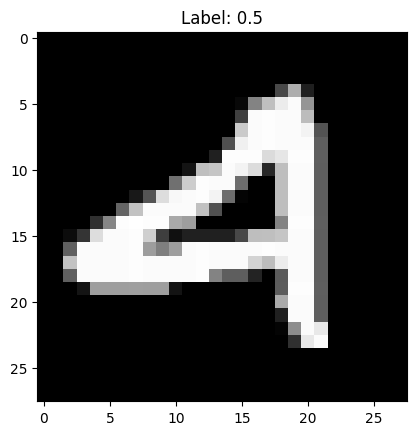

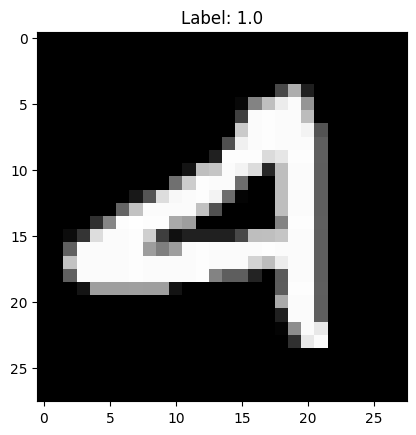

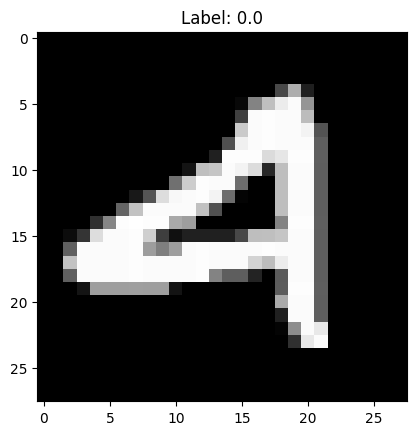

In [24]:
random_train_loader = DataLoader(random_train_data, 
                                      batch_size=256, 
                                      shuffle=False)
reward_train_loader = DataLoader(reward_train_data, 
                                      batch_size=256, 
                                      shuffle=False)
punish_train_loader = DataLoader(punish_train_data, 
                                      batch_size=256, 
                                      shuffle=False)

# Get opto loader
random_opto_loader = generate_opto_loader(random_train_loader, opto_category, plot=True)
reward_opto_loader = generate_opto_loader(reward_train_loader, opto_category, plot=True)
punish_opto_loader = generate_opto_loader(punish_train_loader, opto_category, plot=True)

EP.pre_w: Positive: 49.98%; Negative: 50.02%; Zero: 0.00%
EP.sign_matrix: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
EP.final_weight: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
LHb.pre_w: Positive: 50.06%; Negative: 49.94%; Zero: 0.00%
LHb.sign_matrix: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
LHb.final_weight: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
DAN.pre_w: Positive: 50.78%; Negative: 49.22%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
 ----   Epoch 1  ---- 
training loss: 0.18 | validation loss: 0.15
time elapsed: 1.86 s | predicted time remaining: 35.28 s
 ----   Epoch 2  ---- 
training loss: 0.14 | validation loss: 0.14
time elapsed: 3.71 s | predicted time remaining: 33.43 s
 ----   Epoch 3  ---- 
training loss: 0.10 | validation loss: 0.10
time elapsed: 6.06 s | predicted time remaining: 34.33 s
 ----   Epoch 4  ---- 
training loss: 0.10 | validation loss:

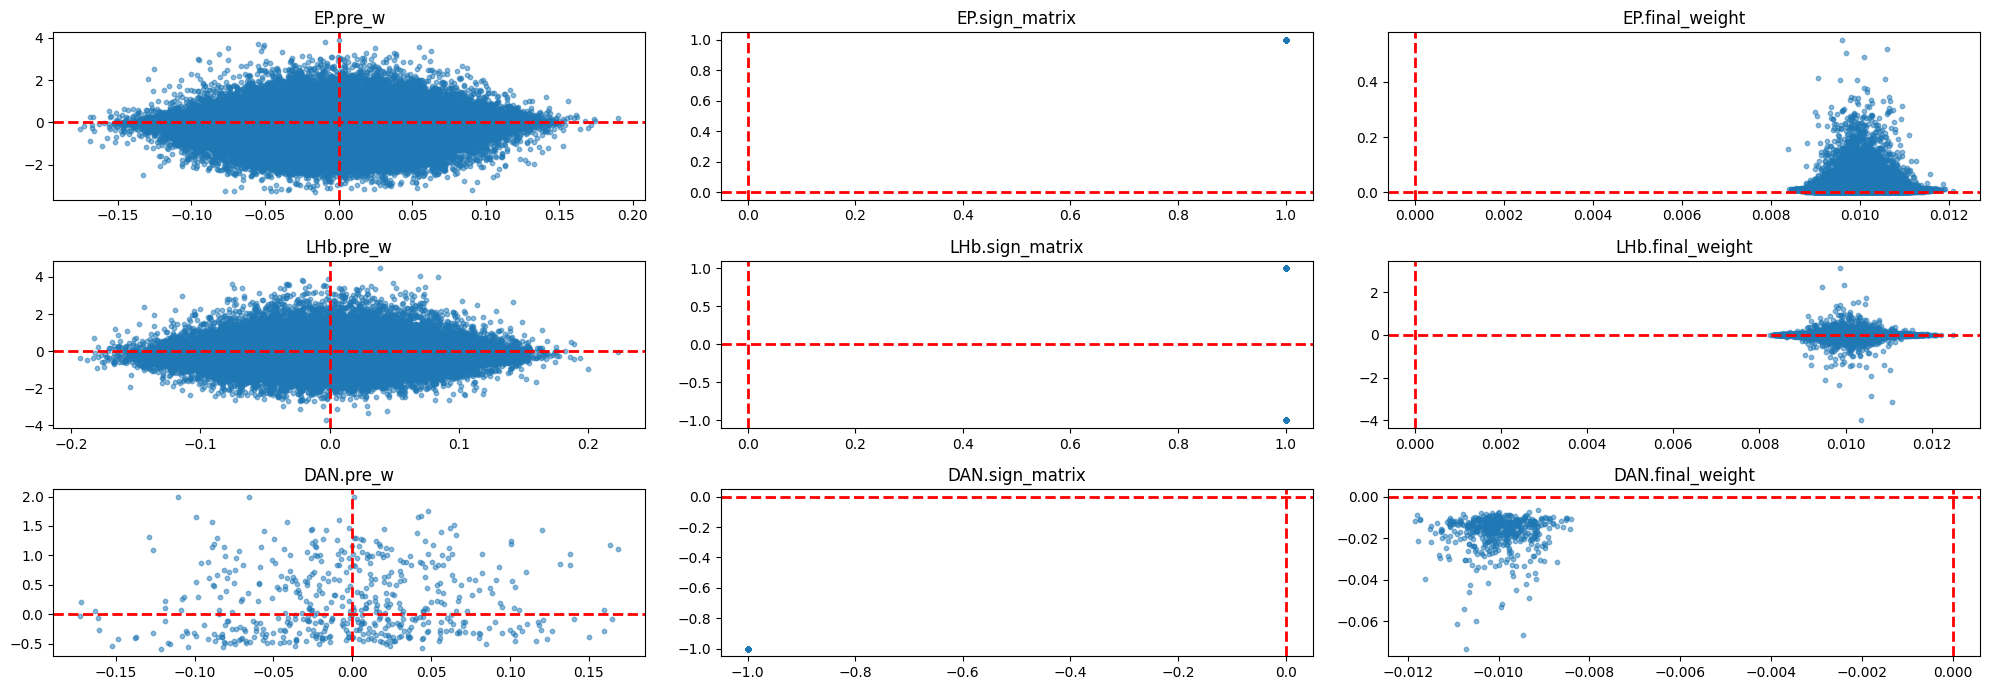

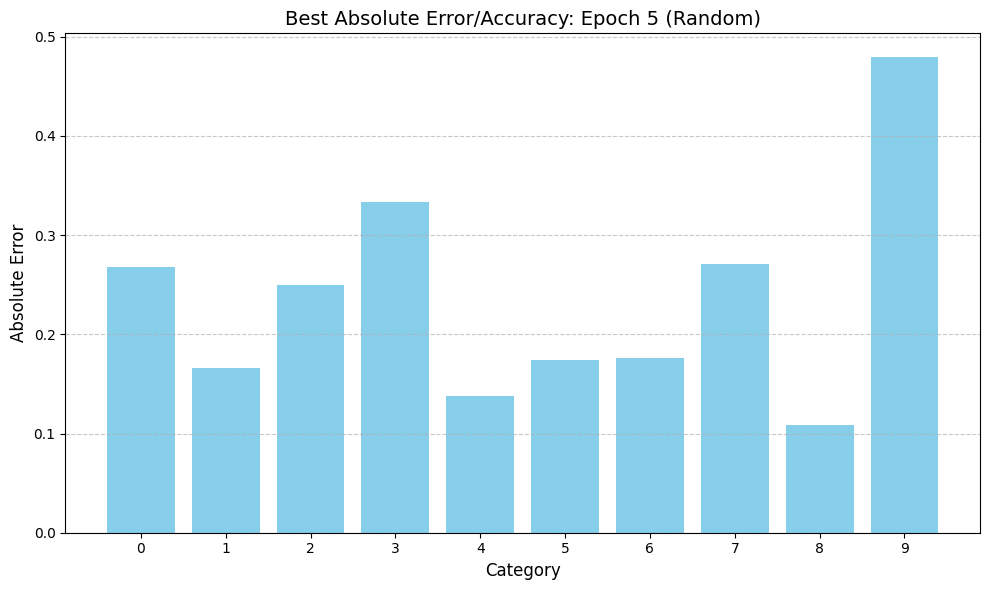

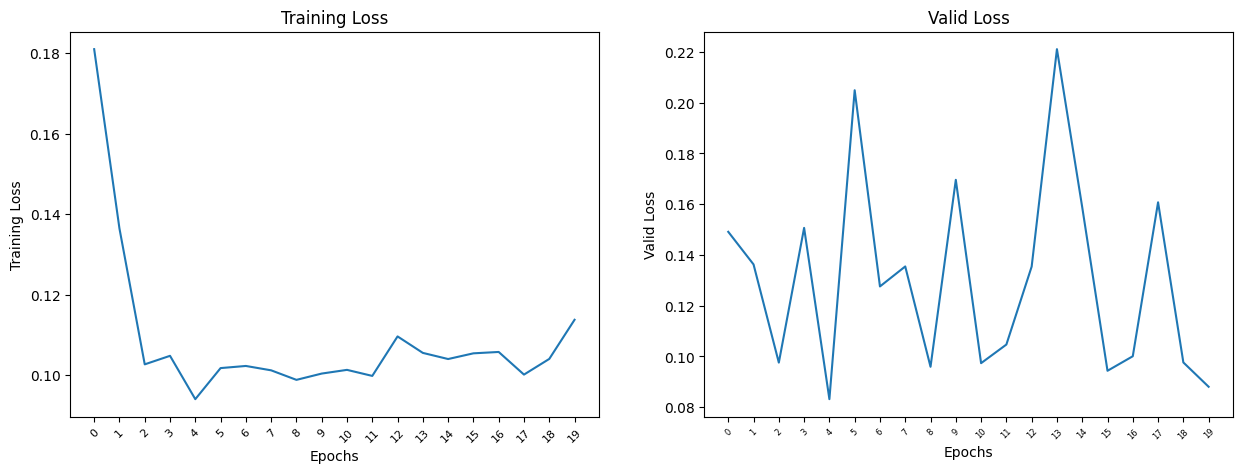

In [25]:
if random_learning:
    # record initial params
    initial_params = model.record_params().copy()
    initial_params_summary[network_name] = [initial_params.copy()]

    # random train
    random_results = TrainerMLE(optimizer = optimizer).train(model, random_train_data, random_valid_data, epochs = epochs, loss_function = loss_function)

    # record trained params
    trained_params = model.record_params().copy()
    trained_params_summary[network_name] = [trained_params.copy()]

    # weight plot
    weight_changes(initial_params, trained_params)

    # store random activations
    random_activations = get_activations(model,random_opto_loader)
    
    # random accuracy/loss
    plot_distance(random_results, name = "Random")
    plot_loss(random_results)

In [26]:
# Before reward/punish training, freeze all layers except LHb
params_to_optimize = [model.LHb.pre_w]

# update adam optimizer
optimizer = optim.Adam(params = params_to_optimize, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

EP.pre_w: Positive: 45.11%; Negative: 54.89%; Zero: 0.00%
EP.sign_matrix: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
EP.final_weight: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
LHb.pre_w: Positive: 27.39%; Negative: 72.61%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
LHb.final_weight: Positive: 50.09%; Negative: 49.91%; Zero: 0.00%
DAN.pre_w: Positive: 53.91%; Negative: 46.09%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
 ----   Epoch 1  ---- 
training loss: 0.12 | validation loss: 0.13
time elapsed: 1.69 s | predicted time remaining: 32.08 s
 ----   Epoch 2  ---- 
training loss: 0.12 | validation loss: 0.14
time elapsed: 3.21 s | predicted time remaining: 28.86 s
 ----   Epoch 3  ---- 
training loss: 0.12 | validation loss: 0.14
time elapsed: 4.71 s | predicted time remaining: 26.71 s
 ----   Epoch 4  ---- 
training loss: 0.12 | validation loss:

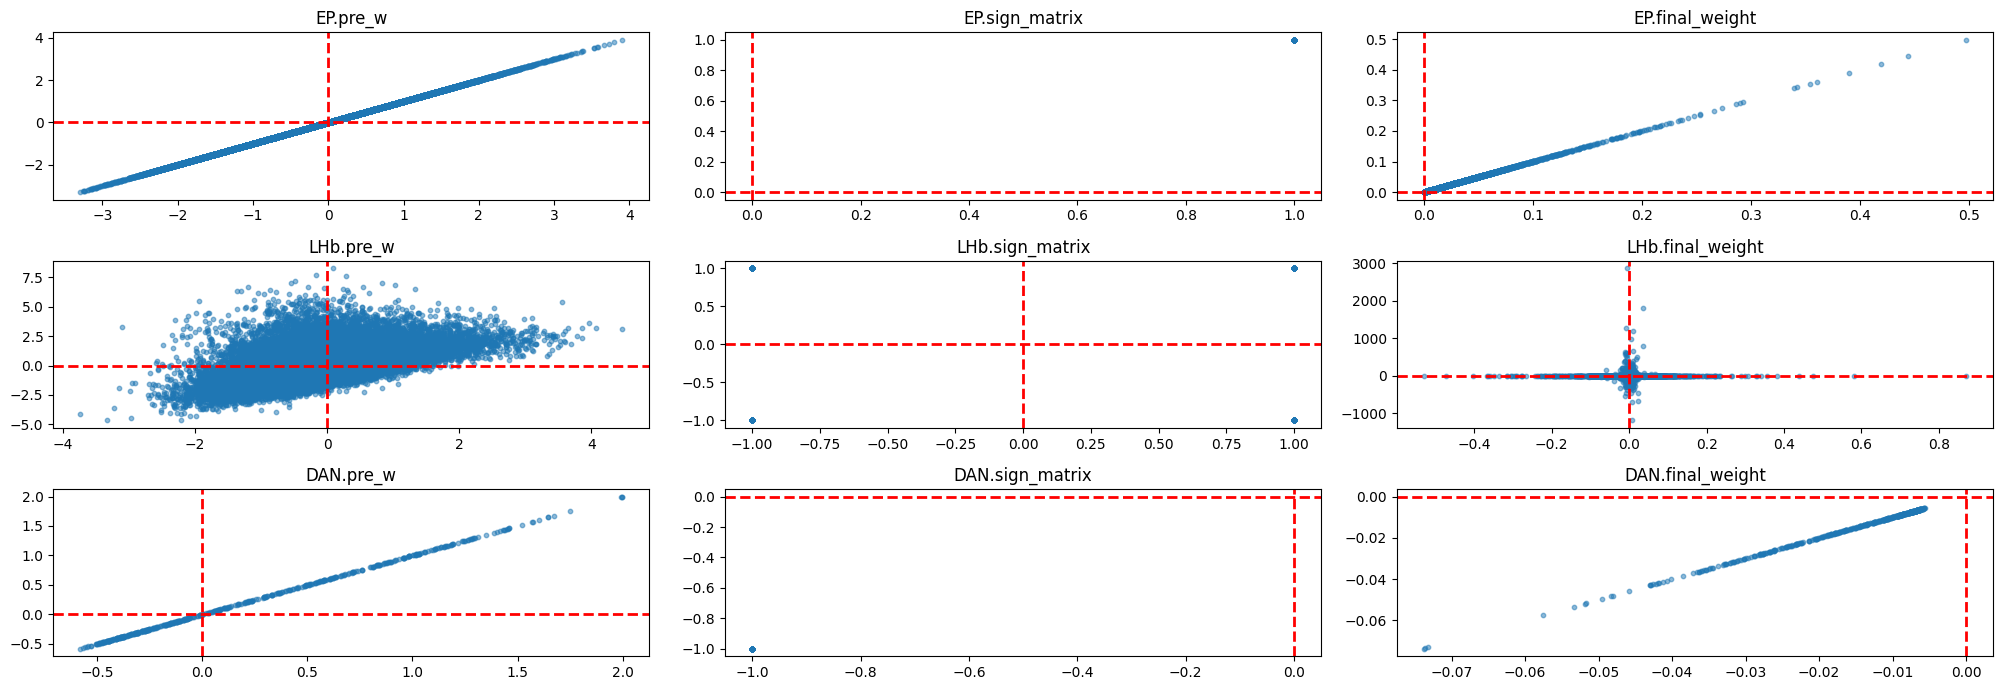

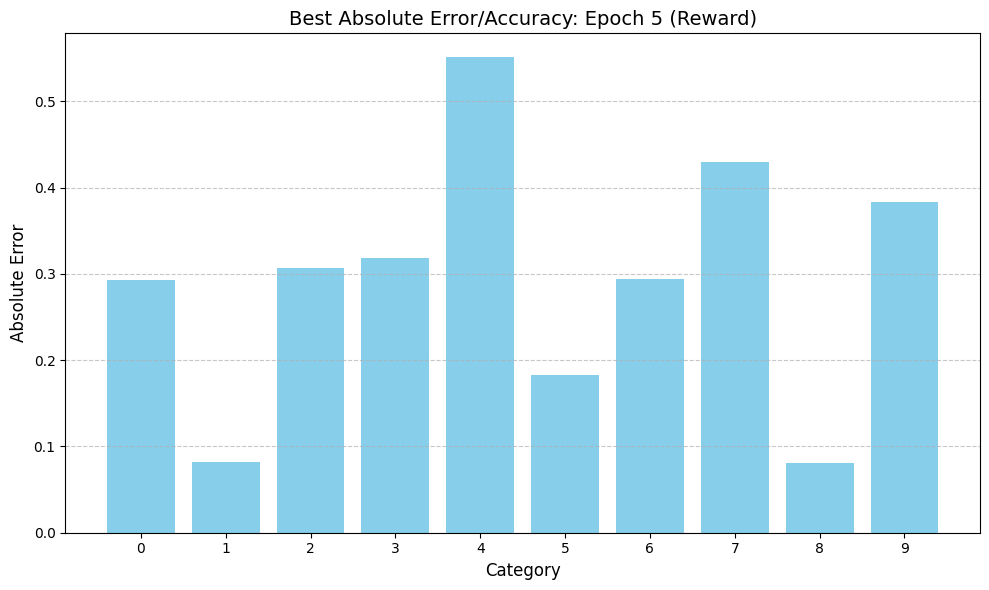

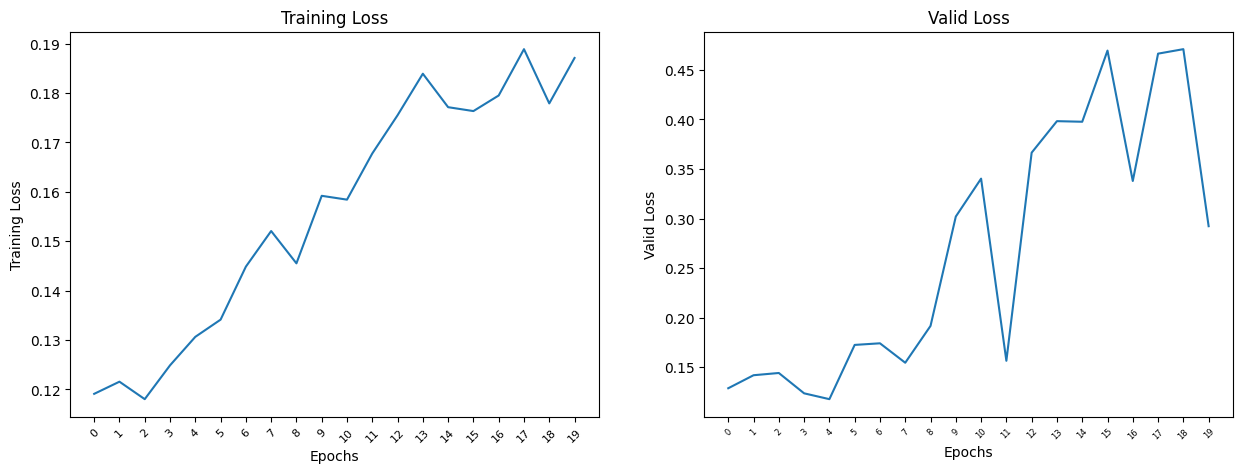

In [27]:
if reward_learning:
    # record initial params
    initial_params = model.record_params().copy()
    initial_params_summary[network_name].append(initial_params.copy())

    # reward train
    reward_results = TrainerMLE(optimizer = optimizer).train(model, reward_train_data, reward_valid_data, epochs = epochs, loss_function = loss_function)

    # record trained params
    trained_params = model.record_params().copy()
    trained_params_summary[network_name].append(trained_params.copy())

    # weight plot
    weight_changes(initial_params, trained_params)

    # store reward activations
    reward_activations = get_activations(model,reward_opto_loader)
    
    # reward accuracy/loss
    plot_distance(reward_results, name = "Reward")
    plot_loss(reward_results)

EP.pre_w: Positive: 45.11%; Negative: 54.89%; Zero: 0.00%
EP.sign_matrix: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
EP.final_weight: Positive: 100.00%; Negative: 0.00%; Zero: 0.00%
LHb.pre_w: Positive: 35.90%; Negative: 64.10%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.13%; Negative: 49.87%; Zero: 0.00%
LHb.final_weight: Positive: 50.13%; Negative: 49.87%; Zero: 0.00%
DAN.pre_w: Positive: 53.91%; Negative: 46.09%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
 ----   Epoch 1  ---- 
training loss: 0.13 | validation loss: 0.43
time elapsed: 1.66 s | predicted time remaining: 31.63 s
 ----   Epoch 2  ---- 
training loss: 0.15 | validation loss: 0.32
time elapsed: 3.02 s | predicted time remaining: 27.16 s
 ----   Epoch 3  ---- 
training loss: 0.16 | validation loss: 0.47
time elapsed: 4.39 s | predicted time remaining: 24.86 s
 ----   Epoch 4  ---- 
training loss: 0.16 | validation loss:

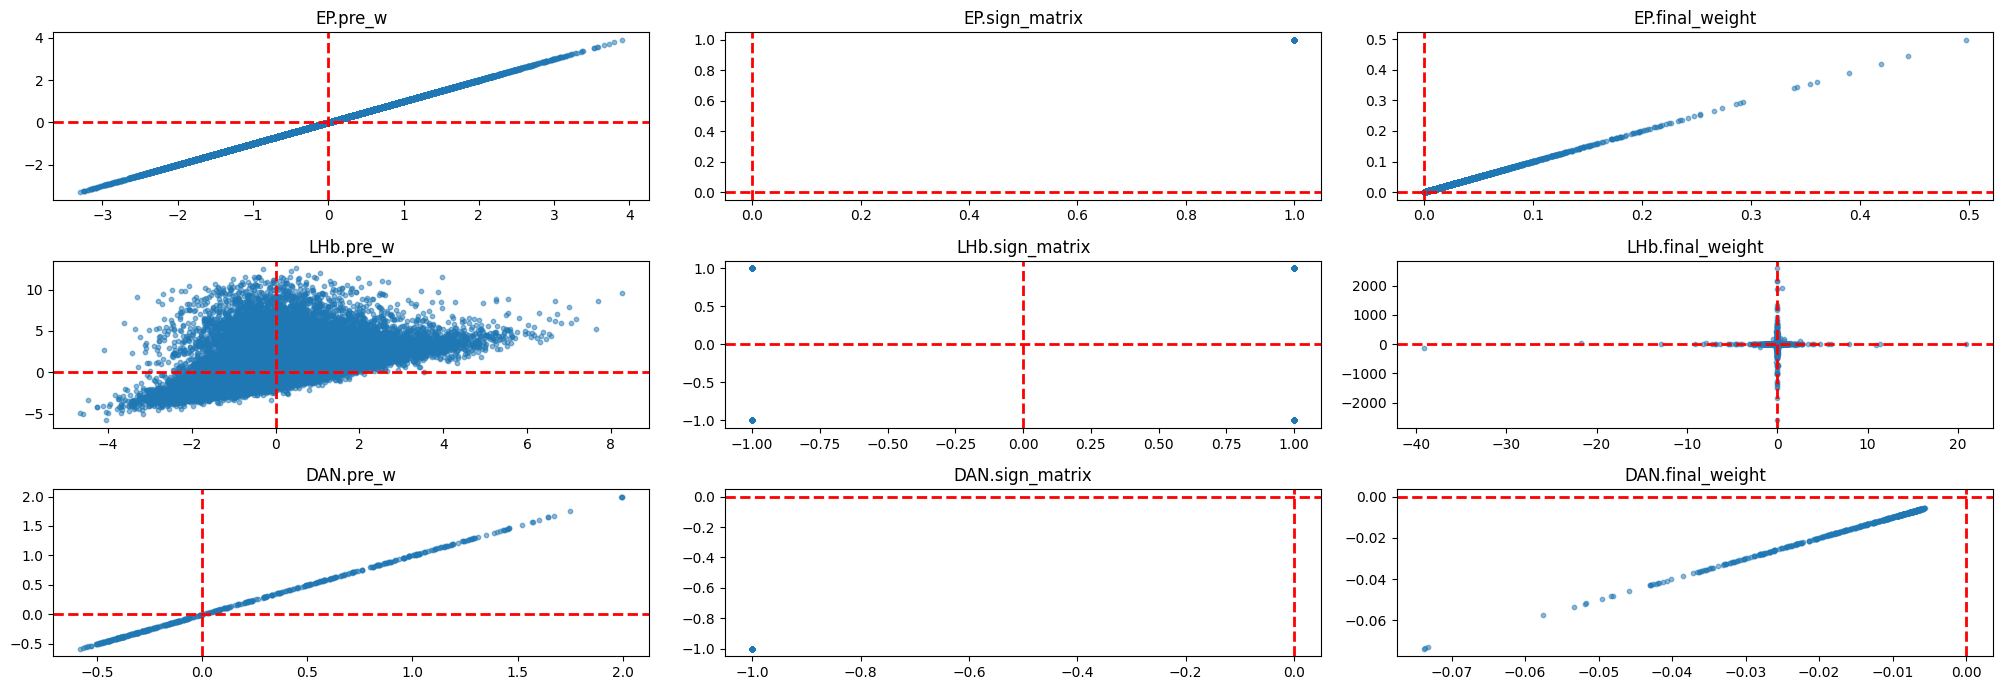

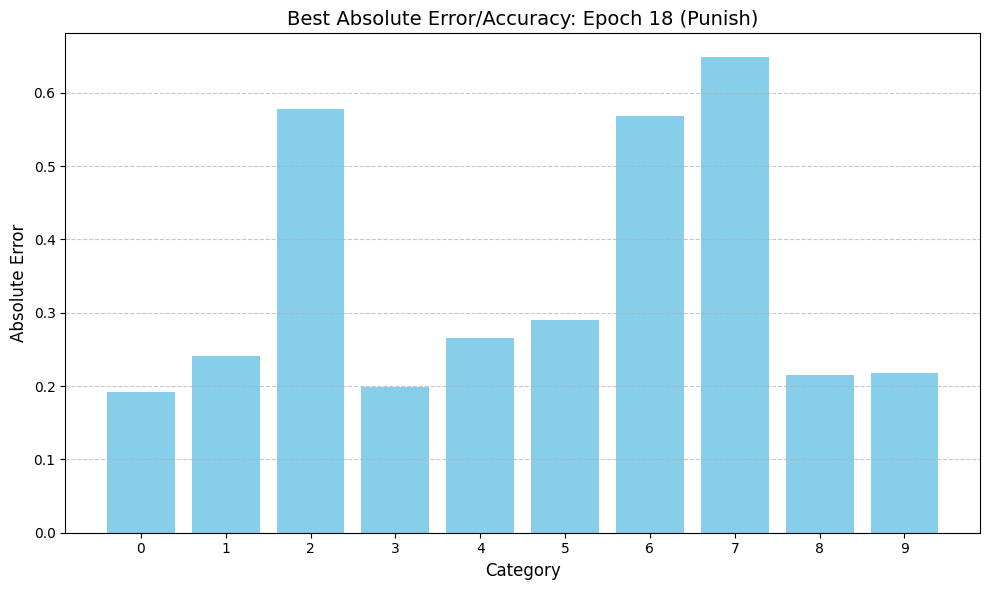

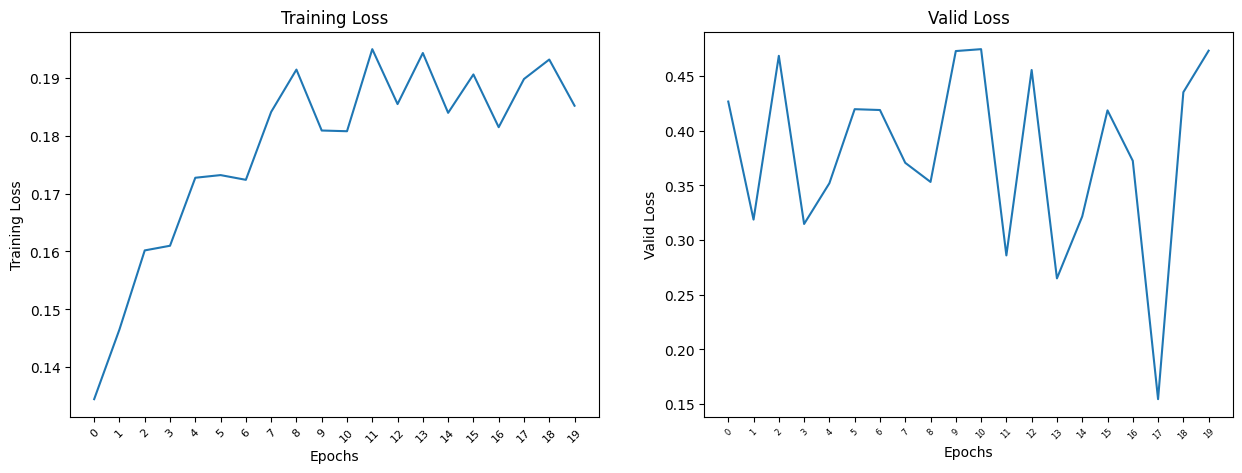

In [28]:
if punish_learning: 
    # record initial params
    initial_params = model.record_params().copy()
    initial_params_summary[network_name].append(initial_params.copy())

    # punish train
    punish_results = TrainerMLE(optimizer = optimizer).train(model, punish_train_data, punish_valid_data, epochs = epochs, loss_function = loss_function)

    # record trained params
    trained_params = model.record_params().copy()
    trained_params_summary[network_name].append(trained_params.copy())

    # weight plot
    weight_changes(initial_params, trained_params)

    # store punish activations
    punish_activations = get_activations(model,punish_opto_loader)
    
    # punish accuracy/loss
    plot_distance(punish_results, name = "Punish")
    plot_loss(punish_results)

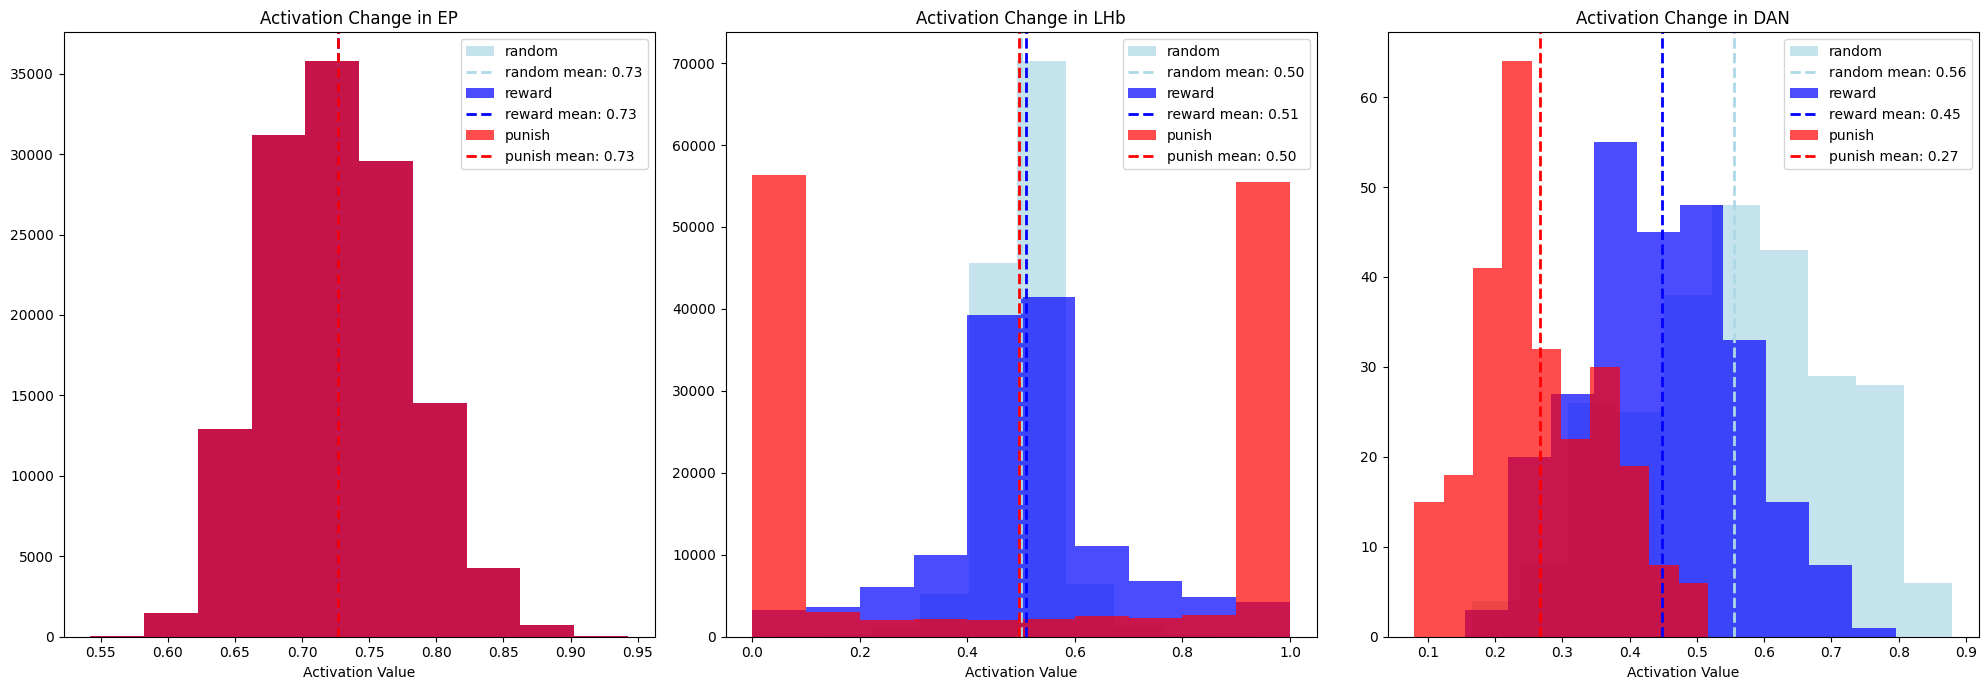

In [29]:
# Plot activation values
activations = []
if random_learning: activations.append(random_activations)
if reward_learning: activations.append(reward_activations)
if punish_learning: activations.append(punish_activations)

plot_layer_activation(activations,plot=[random_learning,reward_learning,punish_learning])

In [26]:
# get initial and trained params for random, reward, punish
random_idx = 0
reward_idx = 1
if reward_learning: punish_idx = 2
else: punish_idx = 1

random_train_initial_params = initial_params_summary['MNIST_TopK_MSE'][random_idx]
random_train_trained_params = trained_params_summary['MNIST_TopK_MSE'][random_idx]

if reward_learning:
    reward_train_initial_params = initial_params_summary['MNIST_TopK_MSE'][reward_idx]
    reward_train_trained_params = trained_params_summary['MNIST_TopK_MSE'][reward_idx]

if punish_learning:
    punish_train_initial_params = initial_params_summary['MNIST_TopK_MSE'][punish_idx]
    punish_train_trained_params = trained_params_summary['MNIST_TopK_MSE'][punish_idx]

In [28]:
# Package into pickle file
packed = {"top_act_neurons": model.opto_choose_neuron, "bottom_act_neurons": model.lowest_choose_neuron}

packed["random_train_initial_params"] = random_train_initial_params
packed["random_train_trained_params"] = random_train_trained_params
train_name = "random"

if reward_learning:
    packed["reward_train_initial_params"] = reward_train_initial_params
    packed["reward_train_trained_params"] = reward_train_trained_params
    train_name += "-reward"

if punish_learning:
    packed["punish_train_initial_params"] = punish_train_initial_params
    packed["punish_train_trained_params"] = punish_train_trained_params
    train_name += "-punish"

# Save the list as a pickle file
print(f'Saving weights to FMNIST_weights_{train_name}.pkl')
with open(f'FMNIST_weights_{train_name}.pkl', 'wb') as f:
    pickle.dump(packed, f)

Saving weights to FMNIST_weights_random-reward-punish.pkl


In [29]:
# # Unpack pickle files
# train_name = "random-reward-punish"

# with open(f'FMNIST_weights_{train_name}.pkl', 'rb') as f:
#     FMNIST_weight = pickle.load(f)

# # Get EP activations and opto indices
# top_act_neurons = FMNIST_weight['top_act_neurons']
# bottom_act_neurons = FMNIST_weight['bottom_act_neurons']

# # Get initial and trained params
# random_learning = "random" in train_name
# reward_learning = "reward" in train_name
# punish_learning = "punish" in train_name

# if random_learning:
#     random_train_initial_params = FMNIST_weight['random_train_initial_params']
#     random_train_trained_params = FMNIST_weight['random_train_trained_params']

# if reward_learning:
#     reward_train_initial_params = FMNIST_weight['reward_train_initial_params']
#     reward_train_trained_params = FMNIST_weight['reward_train_trained_params']
    
# if punish_learning:
#     punish_train_initial_params = FMNIST_weight['punish_train_initial_params']
#     punish_train_trained_params = FMNIST_weight['punish_train_trained_params']

In [30]:
LHb_weight = list(random_train_initial_params)[4]
opto_neurons = model.opto_choose_neuron
lowest_neurons = model.lowest_choose_neuron
LHb_plt_name = 'LHb.final_weight'

# Decide what to plot
plot_random = random_learning
plot_reward = reward_learning
plot_punish = punish_learning

In [31]:
# Step 1: Create a tensor with values from 1 to 512
all_values = torch.arange(0, 512)
non_opto_neurons = all_values[~torch.isin(all_values, torch.tensor(opto_neurons))]

In [32]:
# Calculate total positive and negative weight for each neuron
def calculate_weights(weight_matrix, pre_neurons):
    '''
    Weight matrix is of size n_post x n_pre. Therefore, each row represents the weights of a single post-synaptic neuron
    Thus this function returns the total positive and negative weights coming from pre_neurons for each postsynaptic neuron
    '''
    selected_weights = weight_matrix[:, pre_neurons]
    positive_weights = torch.sum(selected_weights * (selected_weights > 0), dim=1)
    negative_weights = torch.sum(selected_weights * (selected_weights < 0), dim=1)
    
    return positive_weights.numpy(), negative_weights.numpy()

def calculate_EIindex(weight_matrix, pre_neurons):
    '''
    Weight matrix is of size n_post x n_pre. Therefore, each row represents the weights of a single post-synaptic neuron
    Thus this function returns the EI index calculated from the weights coming from pre_neurons for each postsynaptic neuron
    '''
    selected_weights = weight_matrix[:, pre_neurons]
    positive_weights = torch.sum(selected_weights * (selected_weights > 0), dim=1)
    negative_weights = -torch.sum(selected_weights * (selected_weights < 0), dim=1)
    
    return ((negative_weights-positive_weights) / (positive_weights + negative_weights)).numpy()


In [33]:

# top 5% activated neurons
# random train
random_train_trained_exci_top, random_train_trained_inhi_top = calculate_weights(random_train_trained_params[LHb_plt_name], opto_neurons)
random_train_trained_EIindex_top = calculate_EIindex(random_train_trained_params[LHb_plt_name], opto_neurons)

# Caluclate weight differences for each synapse in LHb
random_weight_diff_top = (random_train_trained_params[LHb_plt_name][:, opto_neurons] - random_train_initial_params[LHb_plt_name][:, opto_neurons]).numpy()


In [34]:

# bottom 5% activated neurons
# random train

random_train_trained_exci_bot, random_train_trained_inhi_bot = calculate_weights(random_train_trained_params[LHb_plt_name], lowest_neurons)
random_train_trained_EIindex_bot = calculate_EIindex(random_train_trained_params[LHb_plt_name], lowest_neurons)

# Caluclate weight differences for each synapse in LHb
random_weight_diff_bot = (random_train_trained_params[LHb_plt_name][:, lowest_neurons] - random_train_initial_params[LHb_plt_name][:, lowest_neurons]).numpy()


In [35]:

# all neurons
# random train
random_train_trained_exci_all, random_train_trained_inhi_all = calculate_weights(random_train_trained_params[LHb_plt_name], torch.arange(random_train_trained_params[LHb_plt_name].shape[1]))
random_train_trained_EIindex_all = calculate_EIindex(random_train_trained_params[LHb_plt_name], torch.arange(random_train_trained_params[LHb_plt_name].shape[1]))

# Calculate weight differences for each synapse in LHb
random_weight_diff_all = (random_train_trained_params[LHb_plt_name] - random_train_initial_params[LHb_plt_name]).numpy()



In [36]:

if reward_learning:
    # reward train top 5% activated neurons
    reward_train_trained_exci_top, reward_train_trained_inhi_top = calculate_weights(reward_train_trained_params[LHb_plt_name], opto_neurons)
    reward_train_trained_EIindex_top = calculate_EIindex(reward_train_trained_params[LHb_plt_name], opto_neurons)
    
    # Caluclate weight differences for each synapse in LHb
    reward_weight_diff_top = (reward_train_trained_params[LHb_plt_name][:, opto_neurons] - reward_train_initial_params[LHb_plt_name][:, opto_neurons]).numpy()

    # bottom 5% activated neuron
    # reward train
    reward_train_trained_exci_bot, reward_train_trained_inhi_bot = calculate_weights(reward_train_trained_params[LHb_plt_name], lowest_neurons)
    reward_train_trained_EIindex_bot = calculate_EIindex(reward_train_trained_params[LHb_plt_name], lowest_neurons)

    # Caluclate weight differences for each synapse in LHb
    reward_weight_diff_bot = (reward_train_trained_params[LHb_plt_name][:, lowest_neurons] - reward_train_initial_params[LHb_plt_name][:, lowest_neurons]).numpy()
    
    # all neurons
    # reward train
    reward_train_trained_exci_all, reward_train_trained_inhi_all = calculate_weights(reward_train_trained_params[LHb_plt_name], torch.arange(reward_train_trained_params[LHb_plt_name].shape[1]))
    reward_train_trained_EIindex_all = calculate_EIindex(reward_train_trained_params[LHb_plt_name], torch.arange(reward_train_trained_params[LHb_plt_name].shape[1]))
    
    # Calculate weight differences for each synapse in LHb
    reward_weight_diff_all = (reward_train_trained_params[LHb_plt_name] - reward_train_initial_params[LHb_plt_name]).numpy()

if punish_learning:   
    # punish train top 5% activated neurons
    punish_train_trained_exci_top, punish_train_trained_inhi_top = calculate_weights(punish_train_trained_params[LHb_plt_name], opto_neurons)
    punish_train_trained_EIindex_top = calculate_EIindex(punish_train_trained_params[LHb_plt_name], opto_neurons)

    # Caluclate weight differences for each synapse in LHb
    punish_weight_diff_top = (punish_train_trained_params[LHb_plt_name][:, opto_neurons] - punish_train_initial_params[LHb_plt_name][:, opto_neurons]).numpy()

    # bottom 5% activated neuron
    # punish train
    punish_train_trained_exci_bot, punish_train_trained_inhi_bot = calculate_weights(punish_train_trained_params[LHb_plt_name], lowest_neurons)
    punish_train_trained_EIindex_bot = calculate_EIindex(punish_train_trained_params[LHb_plt_name], lowest_neurons)

    #Caluclate weight differences for each synapse in LHb
    punish_weight_diff_bot = (punish_train_trained_params[LHb_plt_name][:, lowest_neurons] - punish_train_initial_params[LHb_plt_name][:, lowest_neurons]).numpy()

    # all neurons
    # punish train
    punish_train_trained_exci_all, punish_train_trained_inhi_all = calculate_weights(punish_train_trained_params[LHb_plt_name], torch.arange(punish_train_trained_params[LHb_plt_name].shape[1]))
    punish_train_trained_EIindex_all = calculate_EIindex(punish_train_trained_params[LHb_plt_name], torch.arange(punish_train_trained_params[LHb_plt_name].shape[1]))

    # Calculate weight differences for each synapse in LHb
    punish_weight_diff_all = (punish_train_trained_params[LHb_plt_name] - punish_train_initial_params[LHb_plt_name]).numpy()

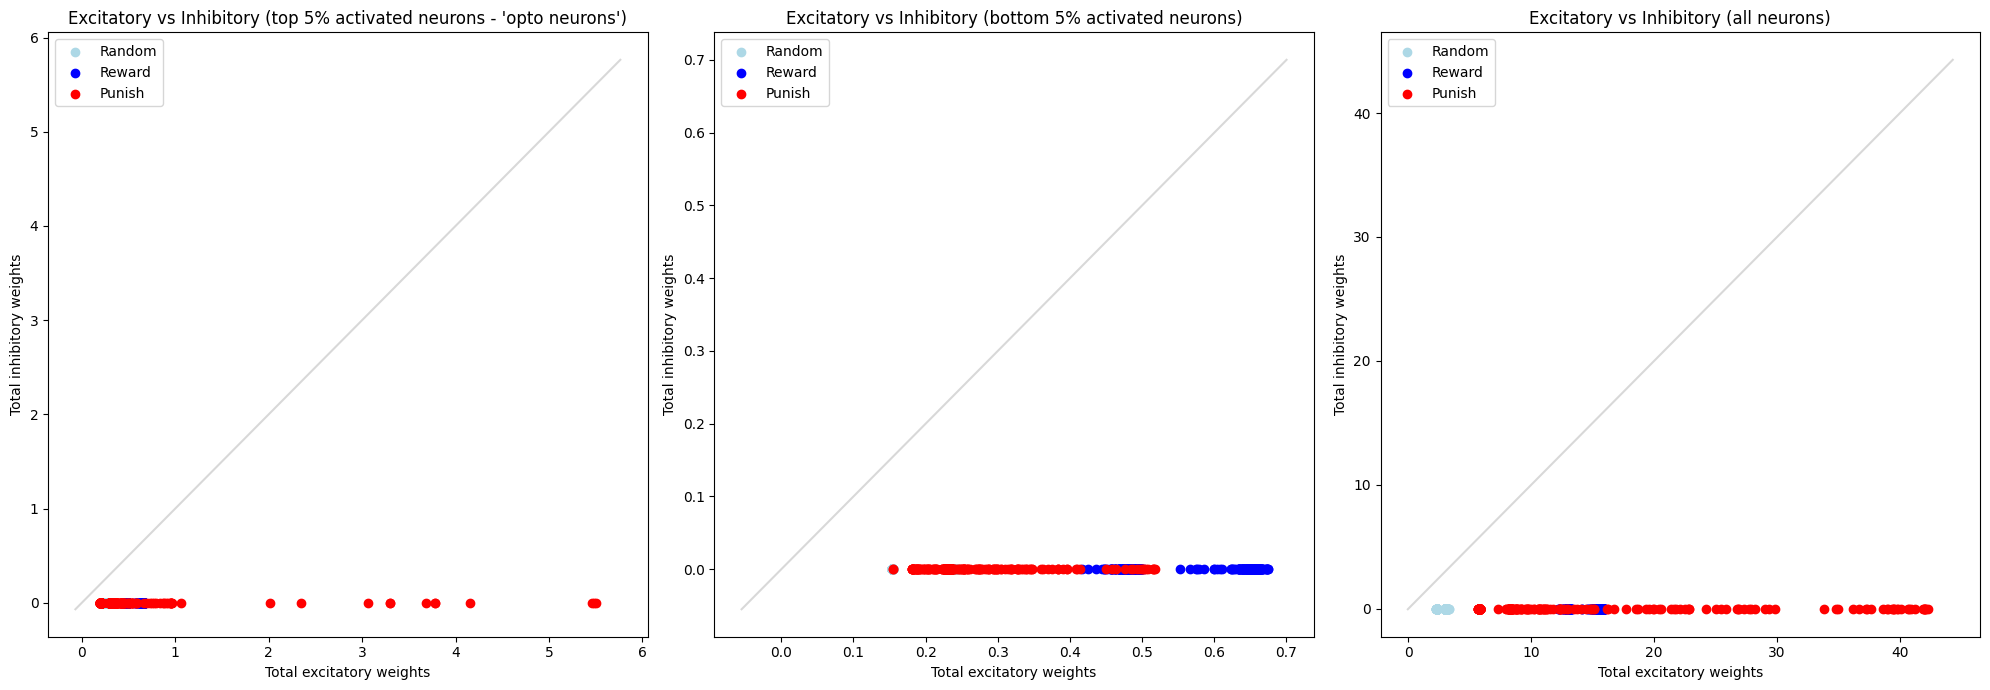

In [37]:
# Create subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharex=False, sharey=False)

# Top 5% activated neurons
if plot_random: axs[0].scatter(random_train_trained_exci_top, -random_train_trained_inhi_top, label="Random", color="lightblue")
if plot_reward: axs[0].scatter(reward_train_trained_exci_top, -reward_train_trained_inhi_top, label="Reward", color="blue")
if plot_punish: axs[0].scatter(punish_train_trained_exci_top, -punish_train_trained_inhi_top, label="Punish", color="red")
axs[0].set_title("Excitatory vs Inhibitory (top 5% activated neurons - 'opto neurons')")
axs[0].legend()
axs[0].set_xlabel("Total excitatory weights")
axs[0].set_ylabel("Total inhibitory weights")
x_vals = np.linspace(min(axs[0].get_xlim()[0], axs[0].get_ylim()[0]), max(axs[0].get_xlim()[1], axs[0].get_ylim()[1]), 100)
axs[0].plot(x_vals, x_vals, '-', color='gray', alpha=0.3)

# Bottom 5% activated neurons
if plot_random: axs[1].scatter(random_train_trained_exci_bot, -random_train_trained_inhi_bot, label="Random", color="lightblue")
if plot_reward: axs[1].scatter(reward_train_trained_exci_top, -reward_train_trained_inhi_top, label="Reward", color="blue")
if plot_punish: axs[1].scatter(punish_train_trained_exci_bot, -punish_train_trained_inhi_bot, label="Punish", color="red")
axs[1].set_title("Excitatory vs Inhibitory (bottom 5% activated neurons)")
axs[1].legend()
axs[1].set_xlabel("Total excitatory weights")
axs[1].set_ylabel("Total inhibitory weights")
x_vals = np.linspace(min(axs[1].get_xlim()[0], axs[1].get_ylim()[0]), max(axs[1].get_xlim()[1], axs[1].get_ylim()[1]), 100)
axs[1].plot(x_vals, x_vals, '-', color='gray', alpha=0.3)

# All neurons
if plot_random: axs[2].scatter(random_train_trained_exci_all, -random_train_trained_inhi_all, label="Random", color="lightblue")
if plot_reward: axs[2].scatter(reward_train_trained_exci_all, -reward_train_trained_inhi_all, label="Reward", color="blue")
if plot_punish: axs[2].scatter(punish_train_trained_exci_all, -punish_train_trained_inhi_all, label="Punish", color="red")
axs[2].set_title("Excitatory vs Inhibitory (all neurons)")
axs[2].legend()
axs[2].set_xlabel("Total excitatory weights")
axs[2].set_ylabel("Total inhibitory weights")
x_vals = np.linspace(min(axs[2].get_xlim()[0], axs[2].get_ylim()[0]), max(axs[2].get_xlim()[1], axs[2].get_ylim()[1]), 100)
axs[2].plot(x_vals, x_vals, '-', color='gray', alpha=0.3)

# Adjust layout
plt.tight_layout()
#plt.savefig('Reward_weight_change_scatter.png', dpi=300)
plt.show()

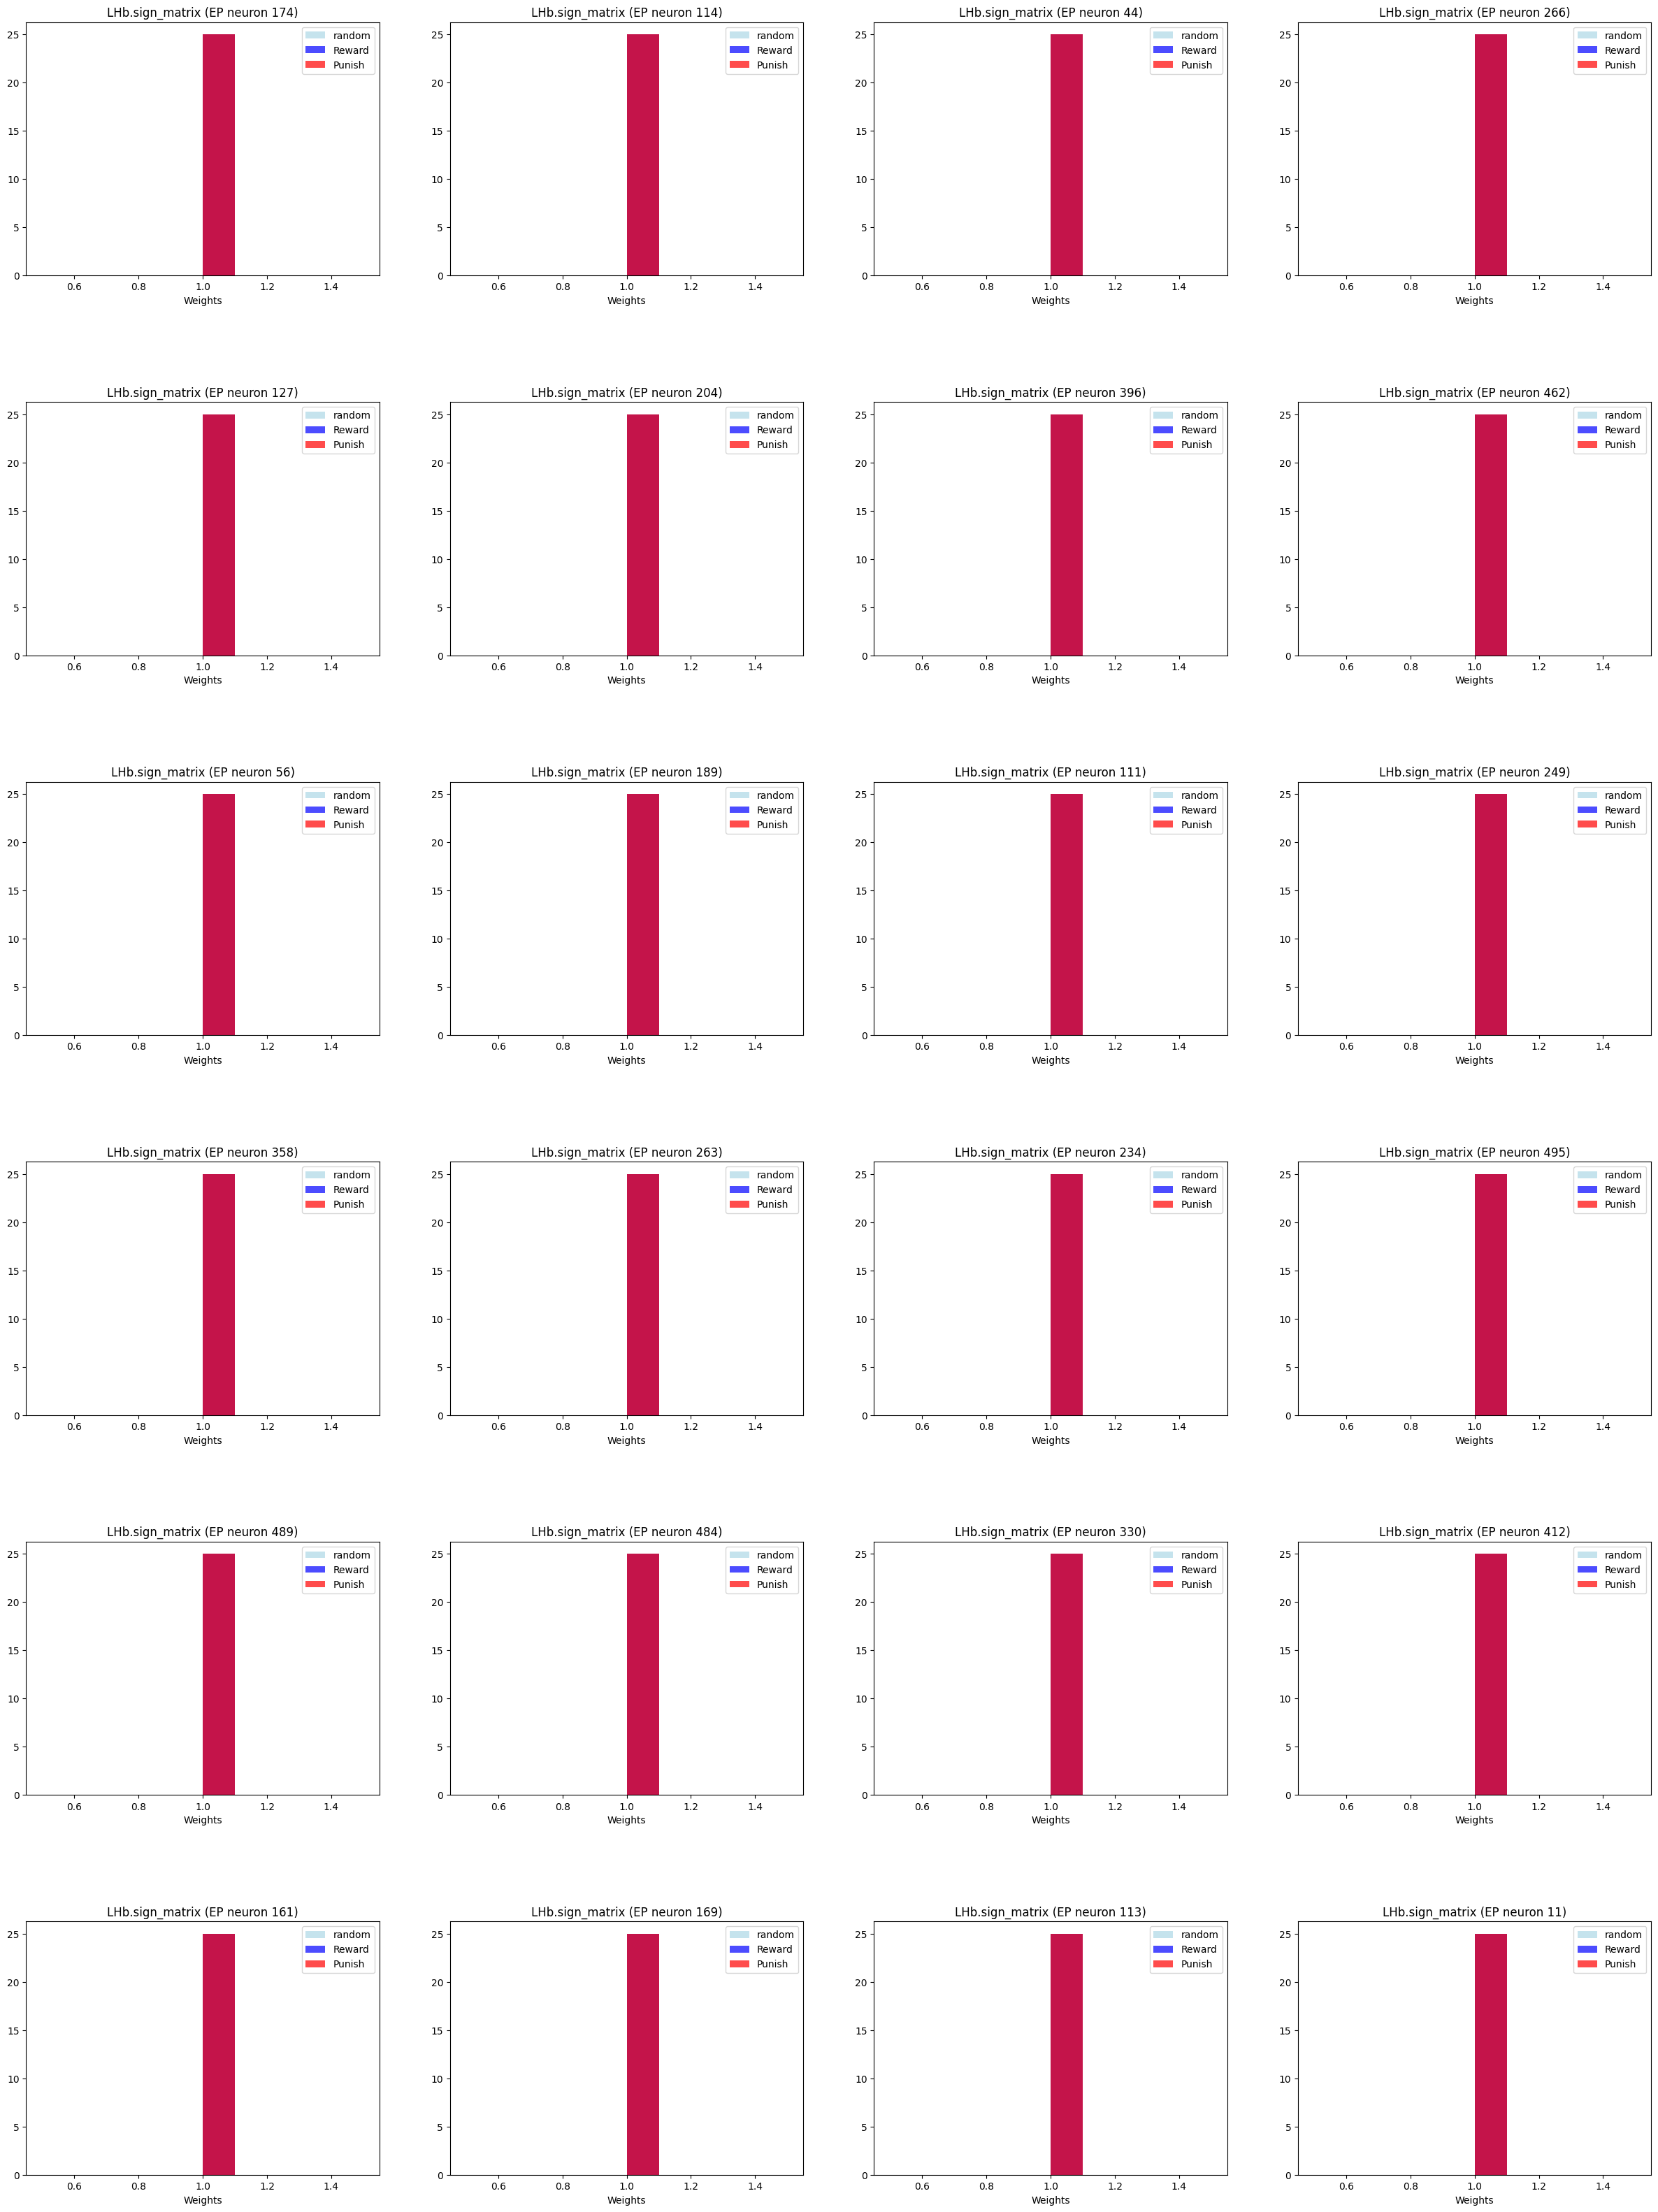

In [38]:
# Plot first 100 neurons' (opto tagged) weights in pre vs post
n_row = 6
n_col = 4

fig, axs = plt.subplots(n_row,n_col,figsize=(30, 40))
plt.subplots_adjust(hspace=0.5)

for i, neuron in enumerate(opto_neurons[:n_row*n_col]):
    if plot_random: axs.flatten()[i].hist(random_train_trained_params[LHb_weight][i,opto_neurons], alpha = 0.7, label = "random", color = "lightblue")
    if plot_reward: axs.flatten()[i].hist(reward_train_trained_params[LHb_weight][i,opto_neurons], alpha = 0.7, label = "Reward", color = "blue")
    if plot_punish: axs.flatten()[i].hist(punish_train_trained_params[LHb_weight][i,opto_neurons], alpha = 0.7, label = "Punish", color = "red")

    axs.flatten()[i].set_xlabel('Weights')
    axs.flatten()[i].set_title(f'%s (EP neuron %d)' %(LHb_weight, neuron))
    axs.flatten()[i].legend()
    
#plt.savefig('Reward_weight_change.png', dpi=300)

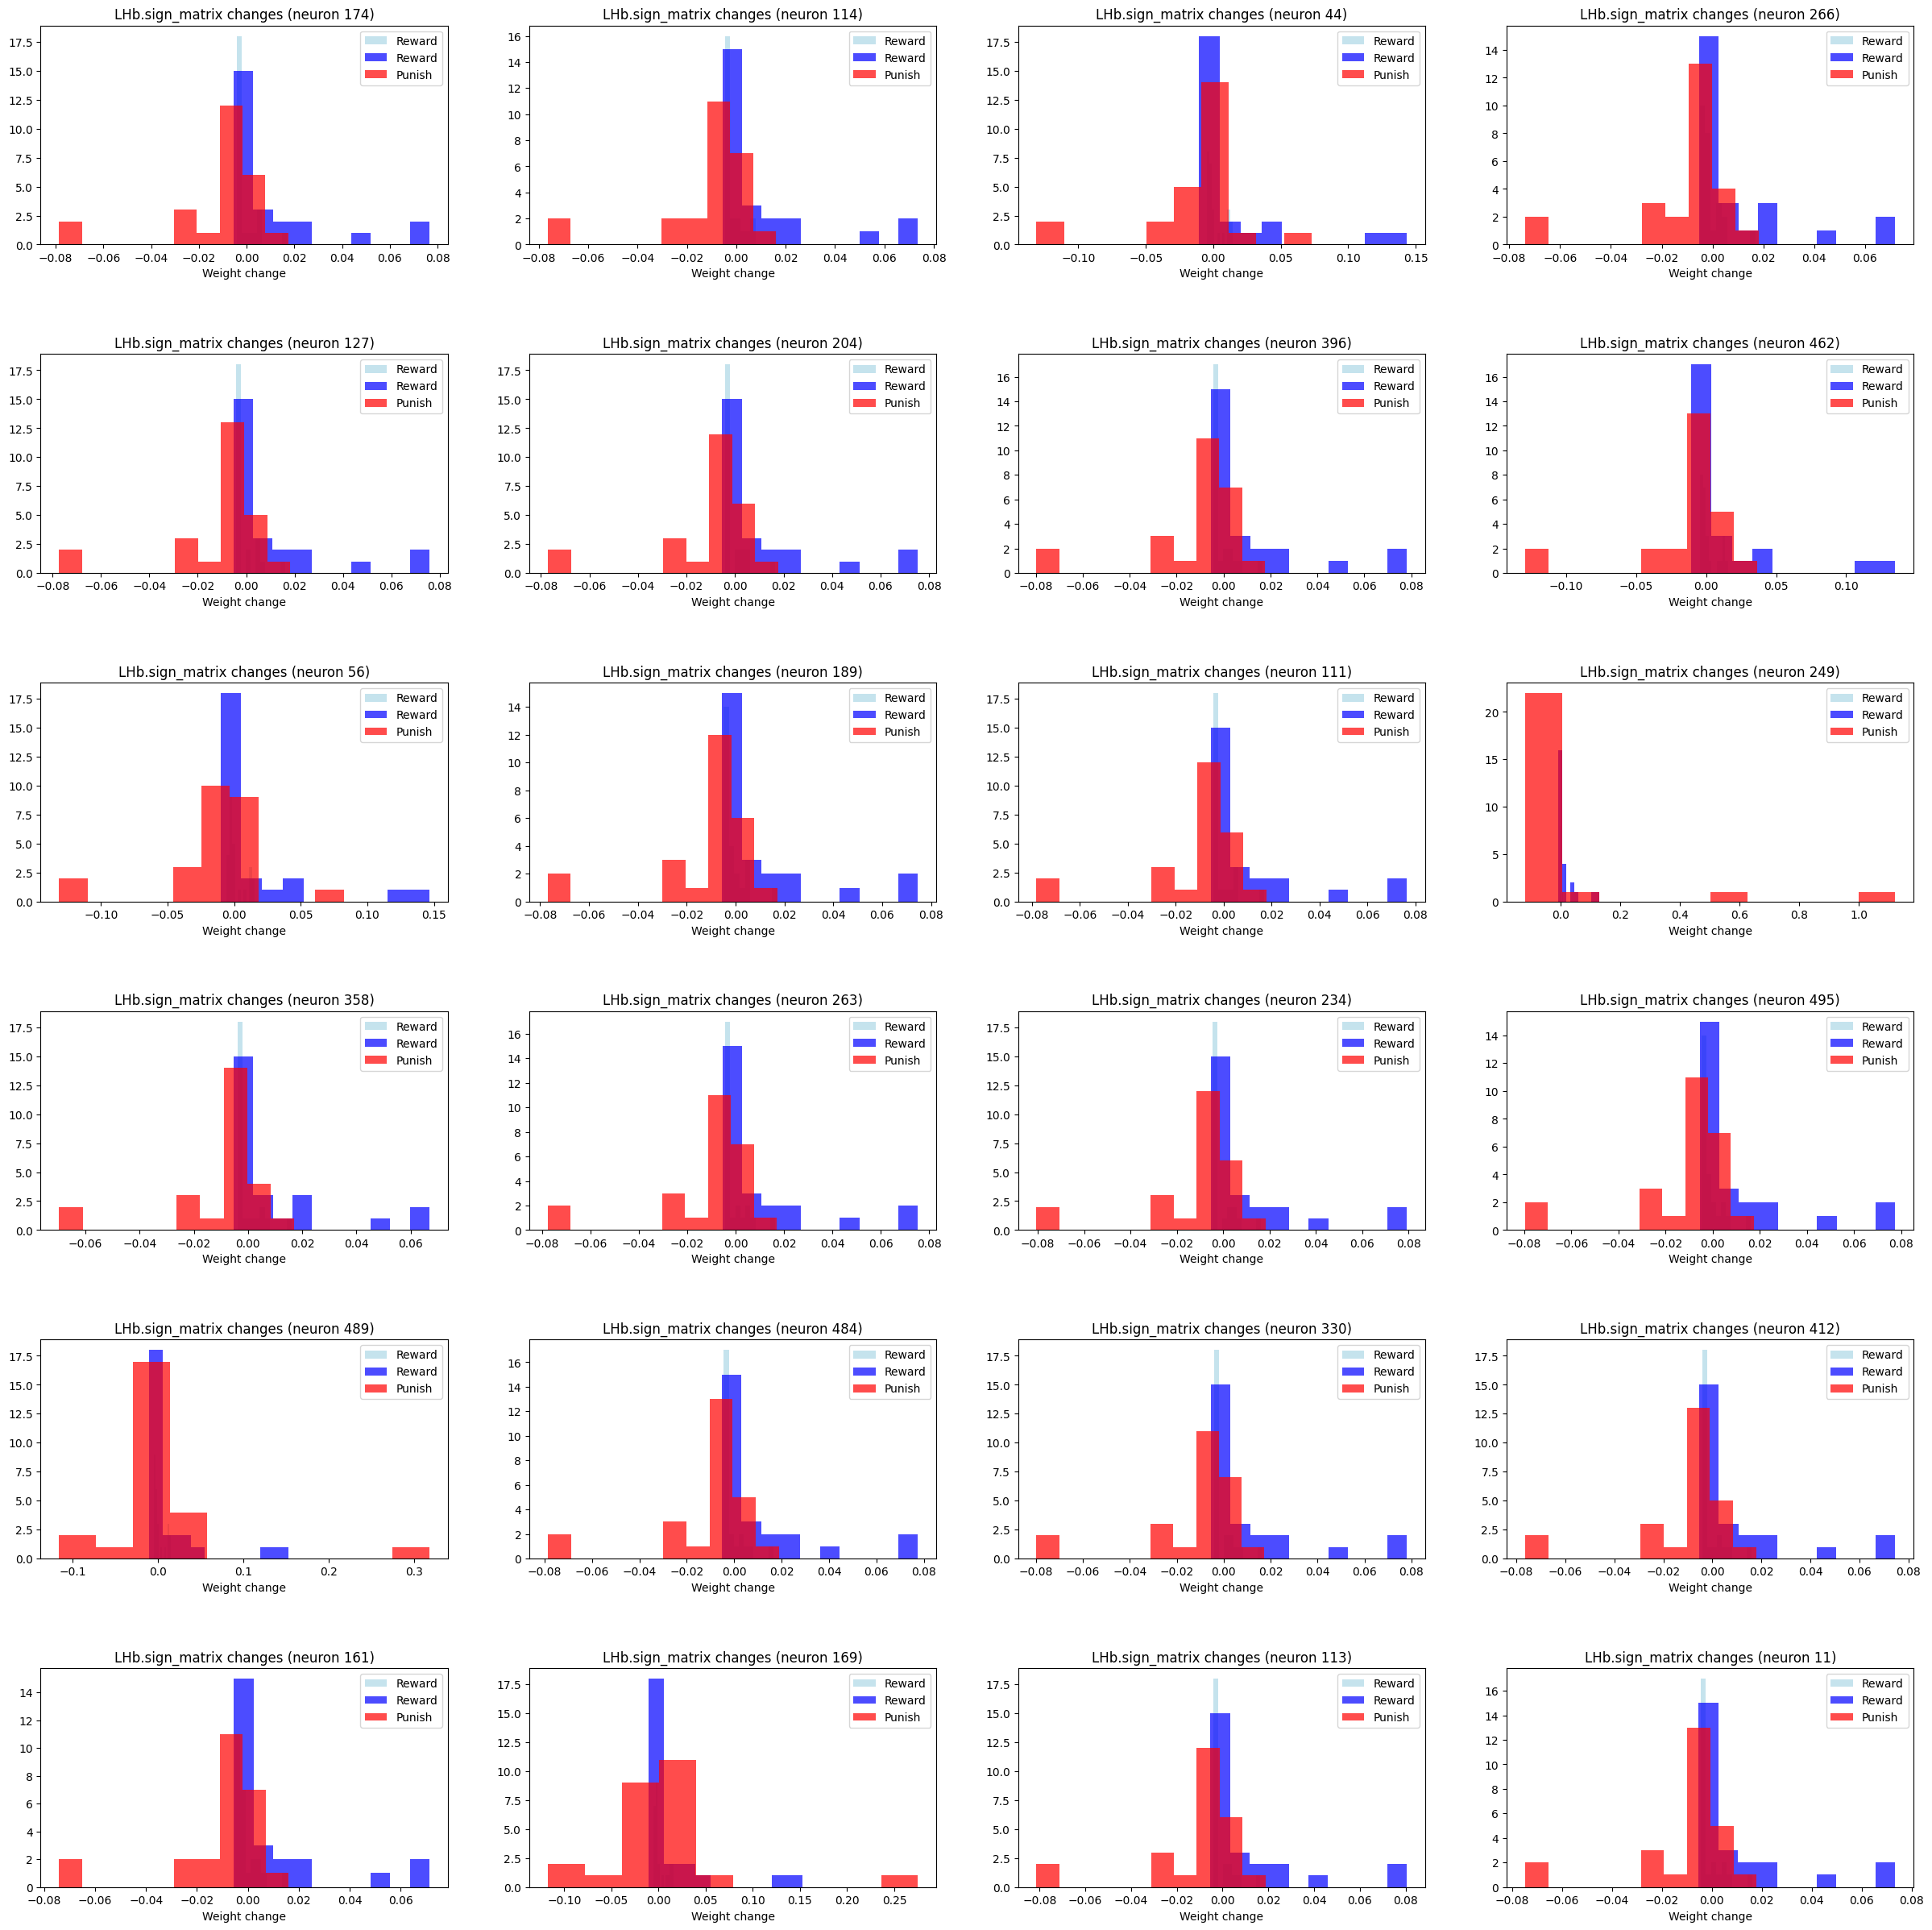

In [39]:
n_row = 6
n_col = 4
fig, axs = plt.subplots(n_row, n_col, figsize=(30, 30))
plt.subplots_adjust(hspace=0.5)

# Use a counter for subplot index
for subplot_idx, neuron in enumerate(opto_neurons[:n_row*n_col]):
    if plot_random: axs.flatten()[subplot_idx].hist(random_weight_diff_top[neuron], alpha=0.7, label="Reward", color="lightblue")
    if plot_reward: axs.flatten()[subplot_idx].hist(reward_weight_diff_top[neuron], alpha=0.7, label="Reward", color="blue")
    if plot_punish: axs.flatten()[subplot_idx].hist(punish_weight_diff_top[neuron], alpha=0.7, label="Punish", color="red")

    axs.flatten()[subplot_idx].set_xlabel('Weight change')
    axs.flatten()[subplot_idx].set_title(f'%s changes (neuron %d)' % (LHb_weight, neuron))
    axs.flatten()[subplot_idx].legend()

#plt.savefig('Reward_weight_diff_change.png', dpi=300)

/var/folders/fl/851gv91d4qs7wzb_myf71kxc0000gn/T/ipykernel_27720/2949550682.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels = labels, vert = vert)


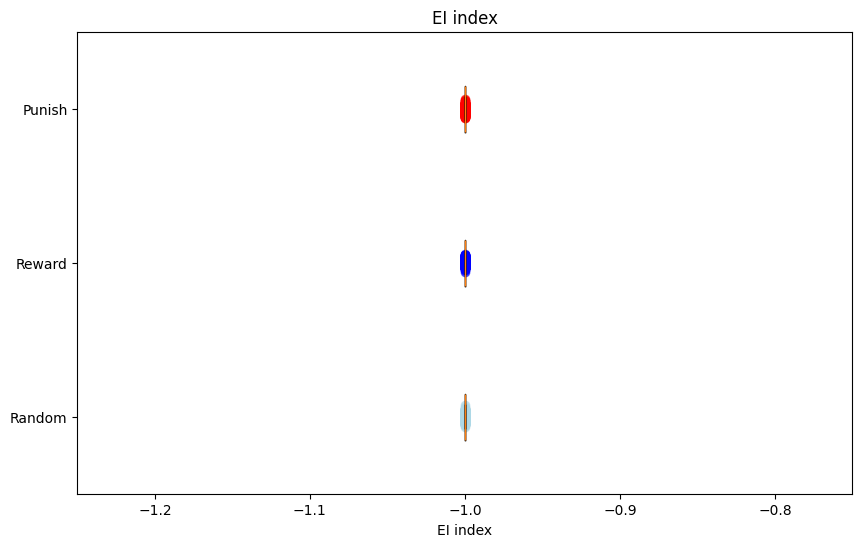

In [41]:
# Plot EI index distribution

# Decide what to plot
if plot_random: 
    data = [random_train_trained_EIindex_top]
    labels = ["Random"]
if reward_learning: 
    data.append(reward_train_trained_EIindex_top)
    labels.append("Reward")
if punish_learning: 
    data.append(punish_train_trained_EIindex_top)
    labels.append("Punish")

# Plot EI index distribution
fig, axs = plt.subplots(1, figsize=(10, 6))
scatterboxplot(data, labels, axs, vert=False)

# t_stat, p_value = stats.ttest_ind(random_train_trained_EIindex_top, punish_train_trained_EIindex_top)
# plt.text(max(max(random_train_trained_EIindex_top), max(punish_train_trained_EIindex_top)) + 0.1, 1.5, f'p = {p_value:.2e}', ha='center', fontsize=12)

axs.set_title('EI index')
axs.set_xlabel('EI index')
axs.set_xlim(-1.25, -0.75)

plt.show()
#plt.savefig('Reward_EI_Index.png', dpi=300)